$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Big Data Research

*Jason Stock*

In [3]:
import pandas as pd
import numpy as np 
import random
import time
from pprint import pprint
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib.pyplot import cm
import matplotlib as mpl
import neuralnetworks as nn
import mlutils as ml
import warnings

warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
mpl.style.use('default')

### Functions
Same `trainNNs, summarize, bestNetwork, printBest` from PA5.

In [4]:
def trainNNs(X, T, trainFraction, hiddenLayerStructures,
             numberRepetitions, numberIterations, classify = False):
    train_p, test_p, timing = [], [], []
    for network in hiddenLayerStructures:
        l_train_p, l_test_p = [], []
        sT = time.time()
        for rep in range(0, numberRepetitions):
            Xtrain, Ttrain, Xtest, Ttest = ml.partition(X, T,
                                                        (trainFraction, 1 - trainFraction),
                                                        classification = classify)
            if classify:
                nnet = nn.NeuralNetworkClassifier(Xtrain.shape[1],
                                                  network,
                                                  np.unique(T).shape[0])
                nnet.train(Xtrain, Ttrain, numberIterations)
                
                Ytrain = nnet.use(Xtrain)
                Ytest  = nnet.use(Xtest)
                
                l_train_p.append( np.sum(Ytrain!=Ttrain)/len(Ttrain) )
                l_test_p.append( np.sum(Ytest!=Ttest)/len(Ttest) )
            else:
                nnet = nn.NeuralNetwork(Xtrain.shape[1],
                                        network,
                                        Ttrain.shape[1])
                nnet.train(Xtrain, Ttrain, numberIterations)
    
                Ytrain = nnet.use(Xtrain)
                Ytest  = nnet.use(Xtest)
            
                l_train_p.append( np.sqrt(np.mean( (Ytrain - Ttrain)**2)) )
                l_test_p.append( np.sqrt(np.mean( (Ytest  - Ttest )**2)) )

        timing.append((time.time() - sT))
        
        train_p.append(l_train_p)
        
        test_p.append(l_test_p)
        
    return [ [hiddenLayerStructures[i], train_p[i], test_p[i], timing[i]]
                for i in range(0, len(hiddenLayerStructures)) ]

def summarize(results):
    for i in range(0, len(results)):
        results[i][1] = np.mean(results[i][1])
        results[i][2] = np.mean(results[i][2])
    
    return results

def bestNetwork(summary):
    min_index = np.argmin( [ [x[2]] for x in summary ] )
    return summary[min_index]

def printBest(best):
    print('\nBest:', best)
    print('\nHidden Layers {} Average Training {:.2f} Testing {:.2f} ' \
          'Took {:.4f} seconds'.format(*best))

### Data Analysis

I begin by looking at the input features to see how they are distributed and correlate to eachother.

Since the weather is consistent across all files (wc1.csv, wc2.csv, ..., wc3.csv) we can just look at one for correlations.

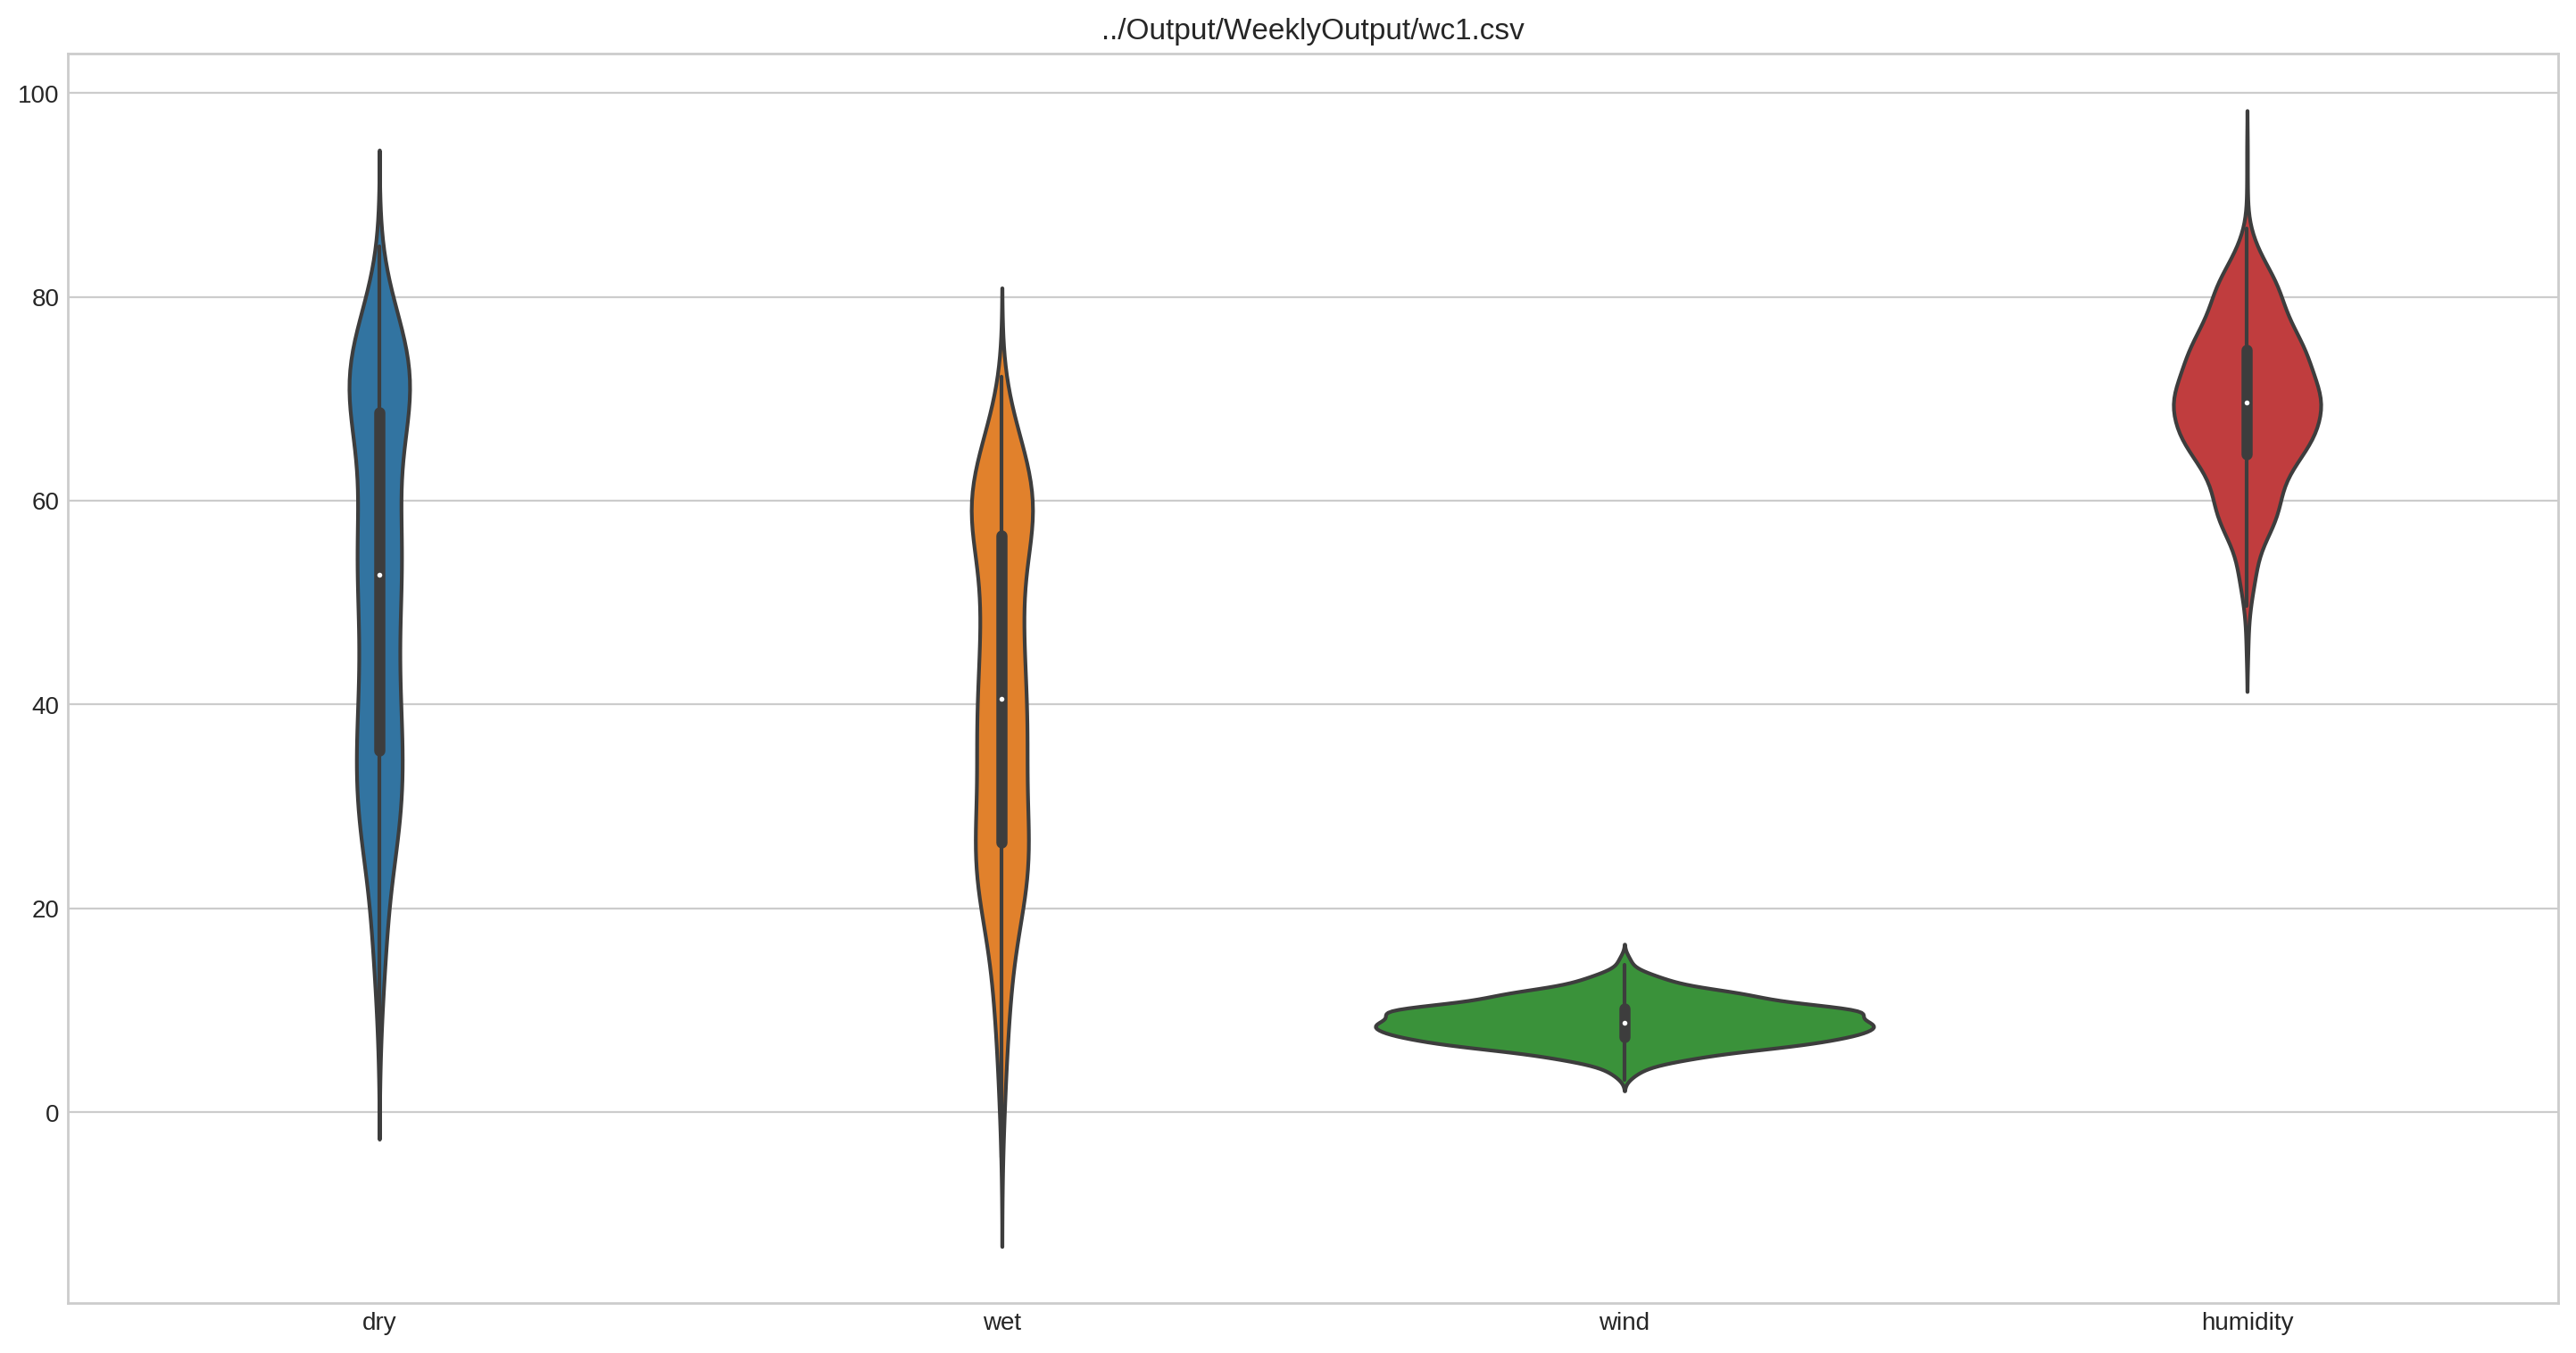

In [3]:
# #############################################################################
# Combination of boxplot and kernel density estimate for Wx data.
# May need to adjust figsize and subplot to fit more graphs.

def violin(num, columns, figheight, subplot_1, subplot_2):
    sns.set_style('whitegrid')
    plt.figure(figsize=(18,figheight))
    for i in range(num):
        plt.subplot(subplot_1,subplot_2,i+1)
        file = '../Output/WeeklyOutput/wc'+str(i+1)+'.csv'
        weather = pd.read_csv(file, sep=',', low_memory=False, 
                               names = ['date', 'dry', 'wet', 'wind',
                                        'humidity', 'district', 'homicide', 'robbery',
                                        'battery', 'assault', 'burglary', 'theft',
                                        'motor', 'weapons'], usecols = columns)
        plt.title(file)
        sns.violinplot(data=weather)

    plt.show()

NUM_PLOTS = 1
columns = range(1,5)
subplot_1 = 2
subplot_2 = 1
figheight = 20
violin(NUM_PLOTS, columns, figheight, subplot_1, subplot_2)

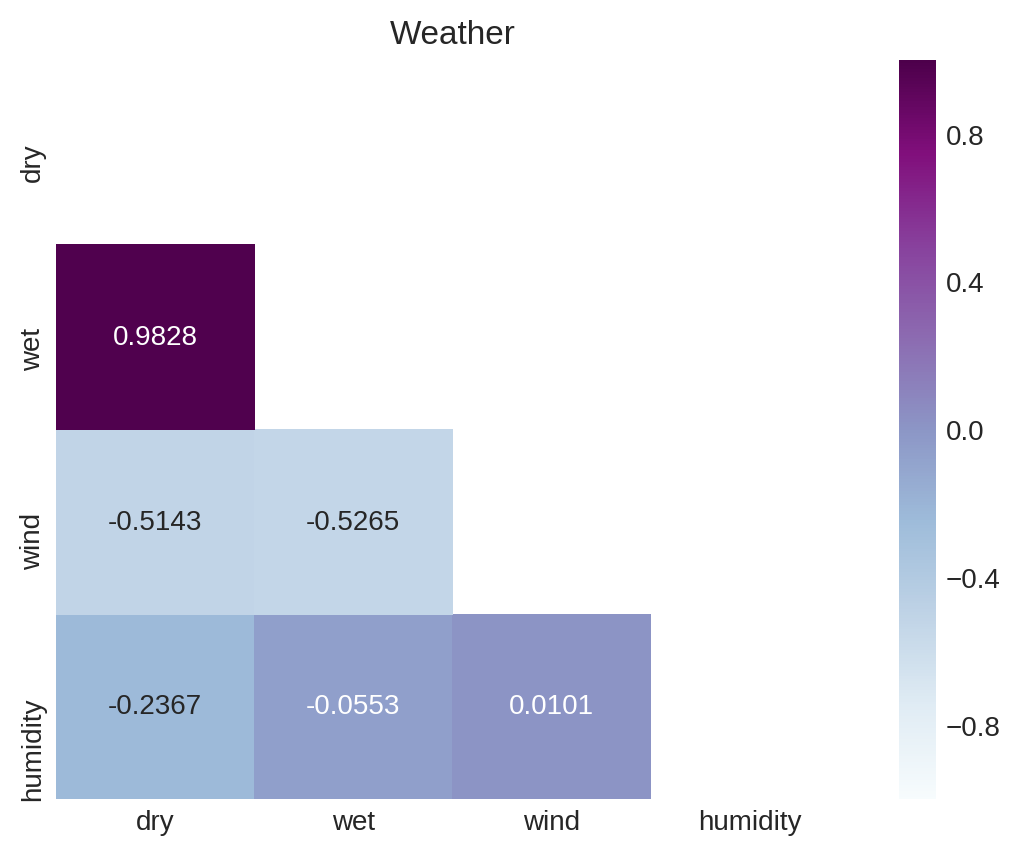

In [4]:
# #############################################################################
# Heatmap from the laster weather set of weather data read

district = '5'

file = '../Output/WeeklyOutput/wc'+district+'.csv'
weather = pd.read_csv(file, sep=',', low_memory=False, 
                       names = ['date', 'dry', 'wet', 'wind',
                                'humidity', 'district', 'homicide', 'robbery',
                                'battery', 'assault', 'burglary', 'theft',
                                'motor', 'weapons'], usecols = columns)

corr = weather.corr(method='pearson')
mask = np.zeros_like(corr,dtype=np.bool)

# set to False to view full matrix
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, annot=True, fmt='.4f', mask=mask, cmap='BuPu', robust=True)
plt.title('Weather')

plt.show()

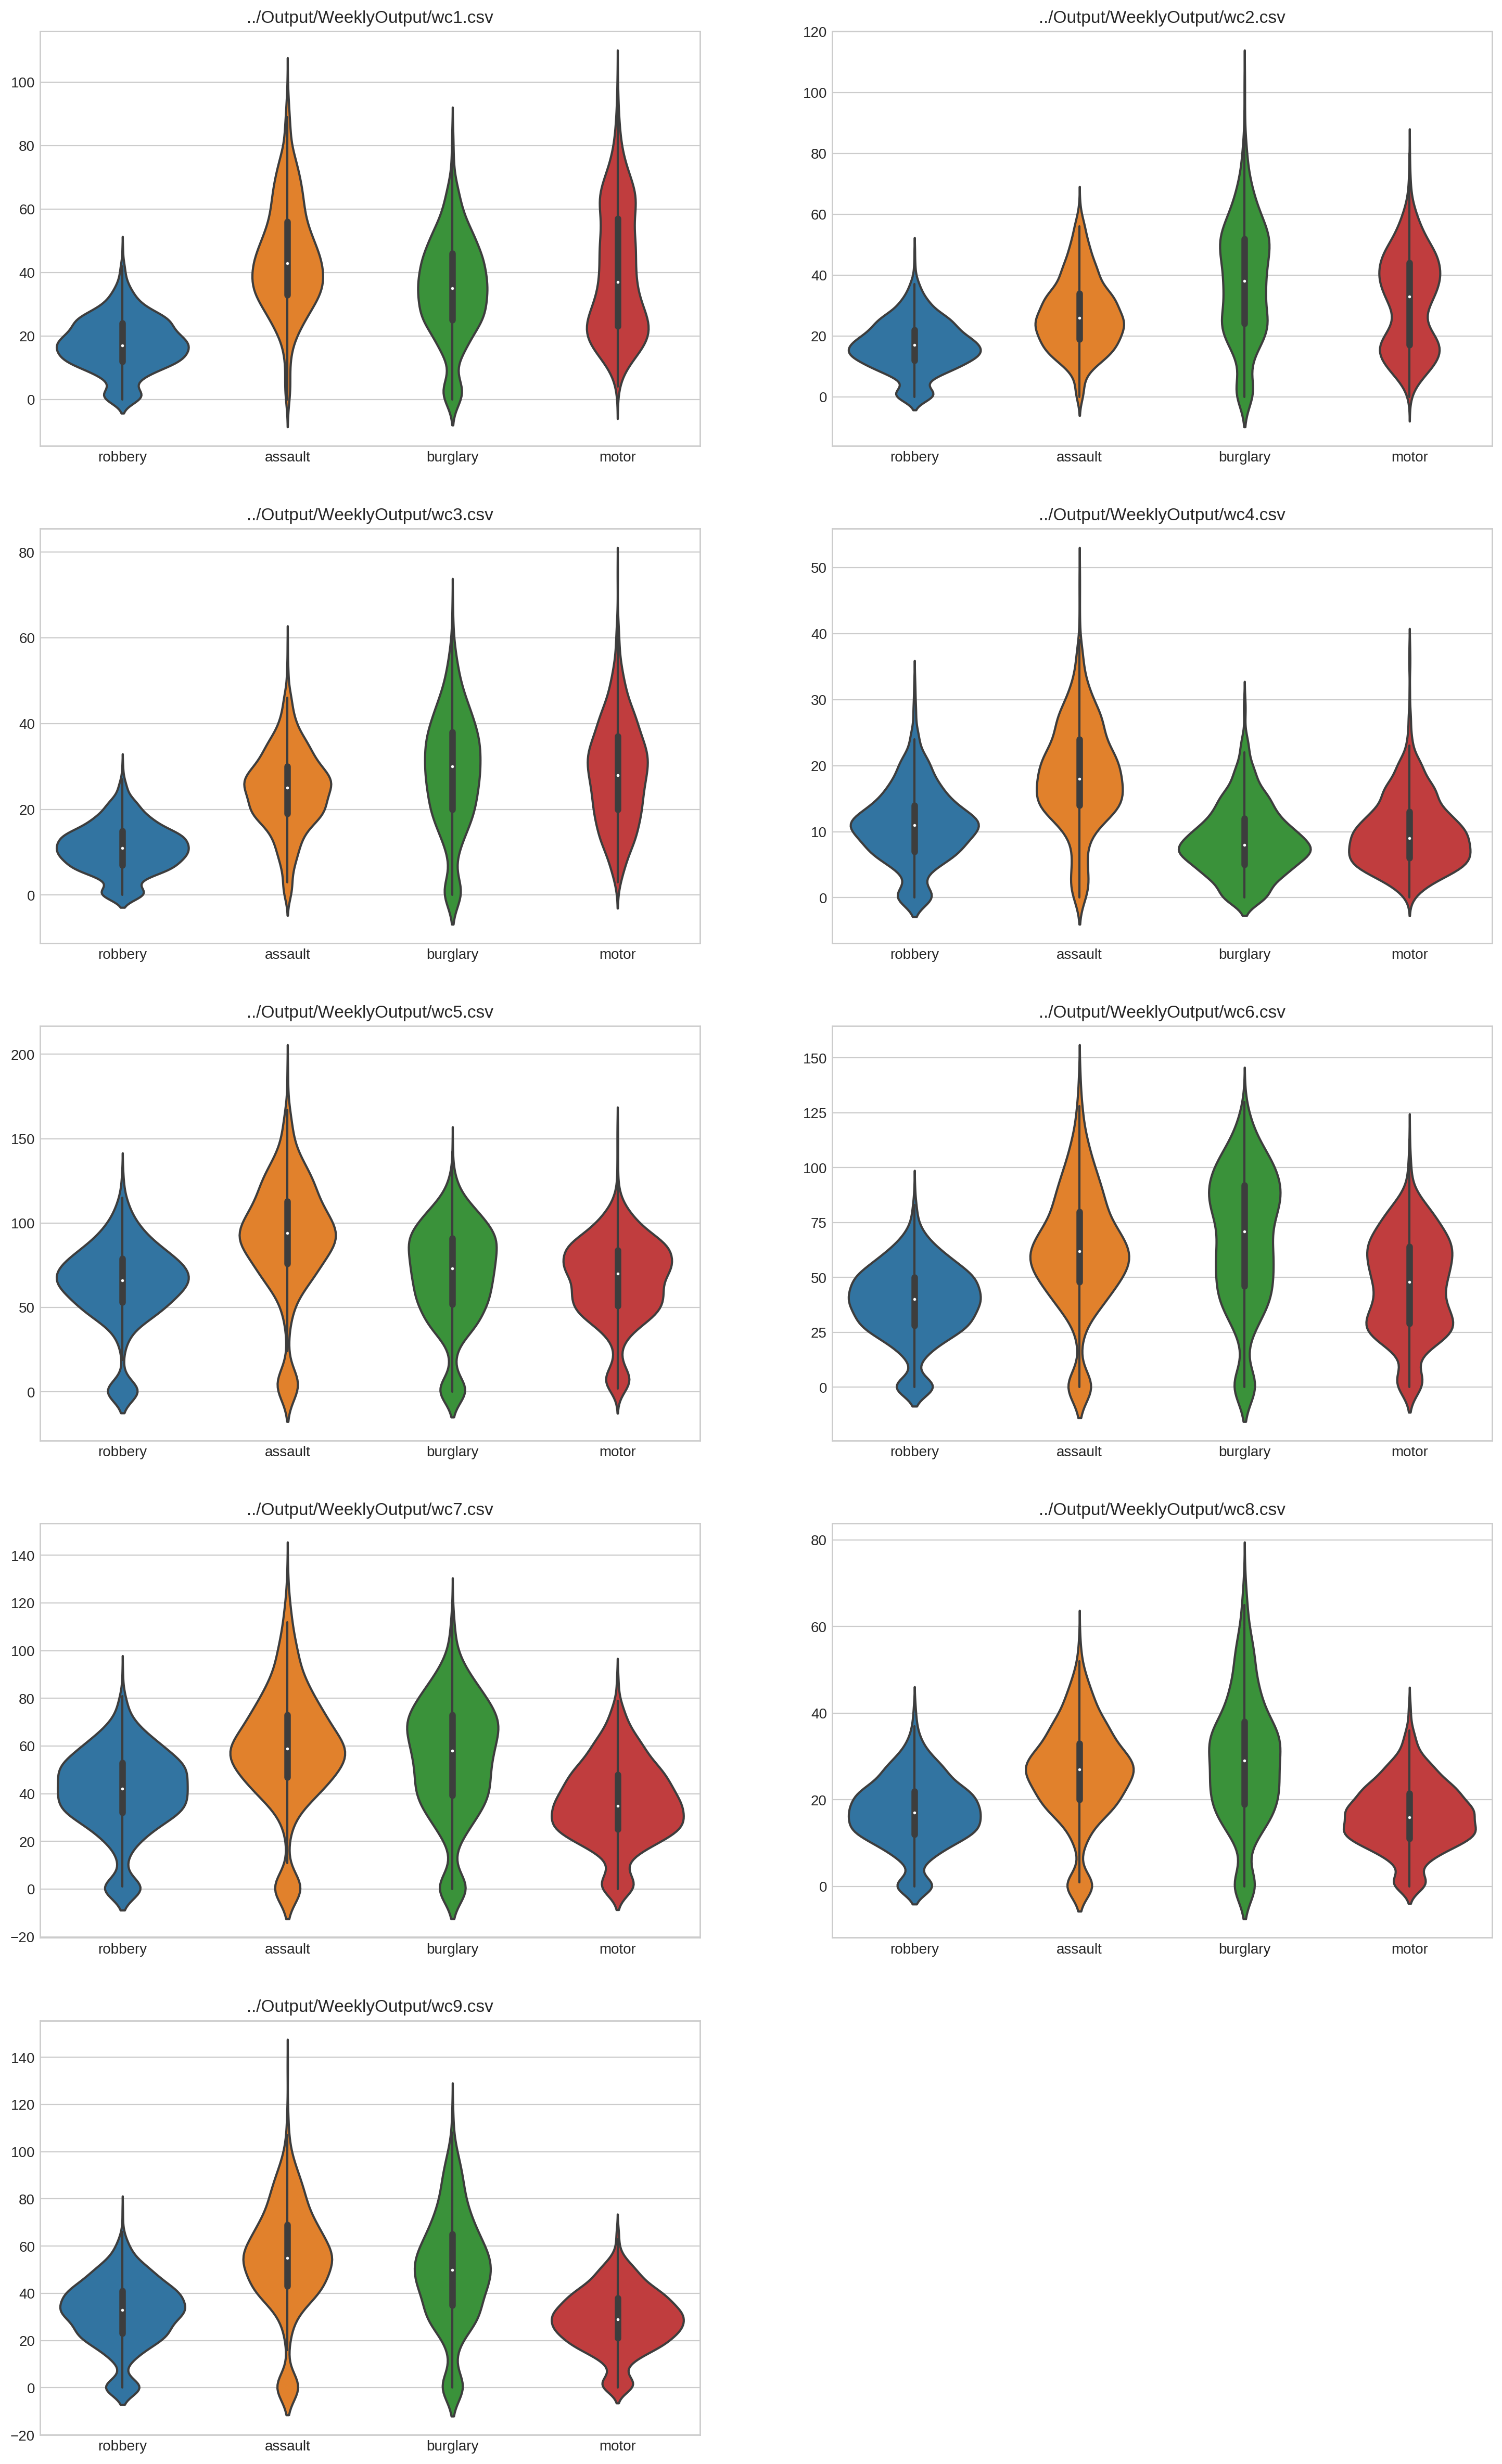

In [5]:
# #############################################################################
# Look at output features (crime) over districts

NUM_PLOTS = 9
columns = [7, 9, 10, 12]
subplot_1 = 5
subplot_2 = 2
figheight = 30
violin(NUM_PLOTS, columns, figheight, subplot_1, subplot_2)

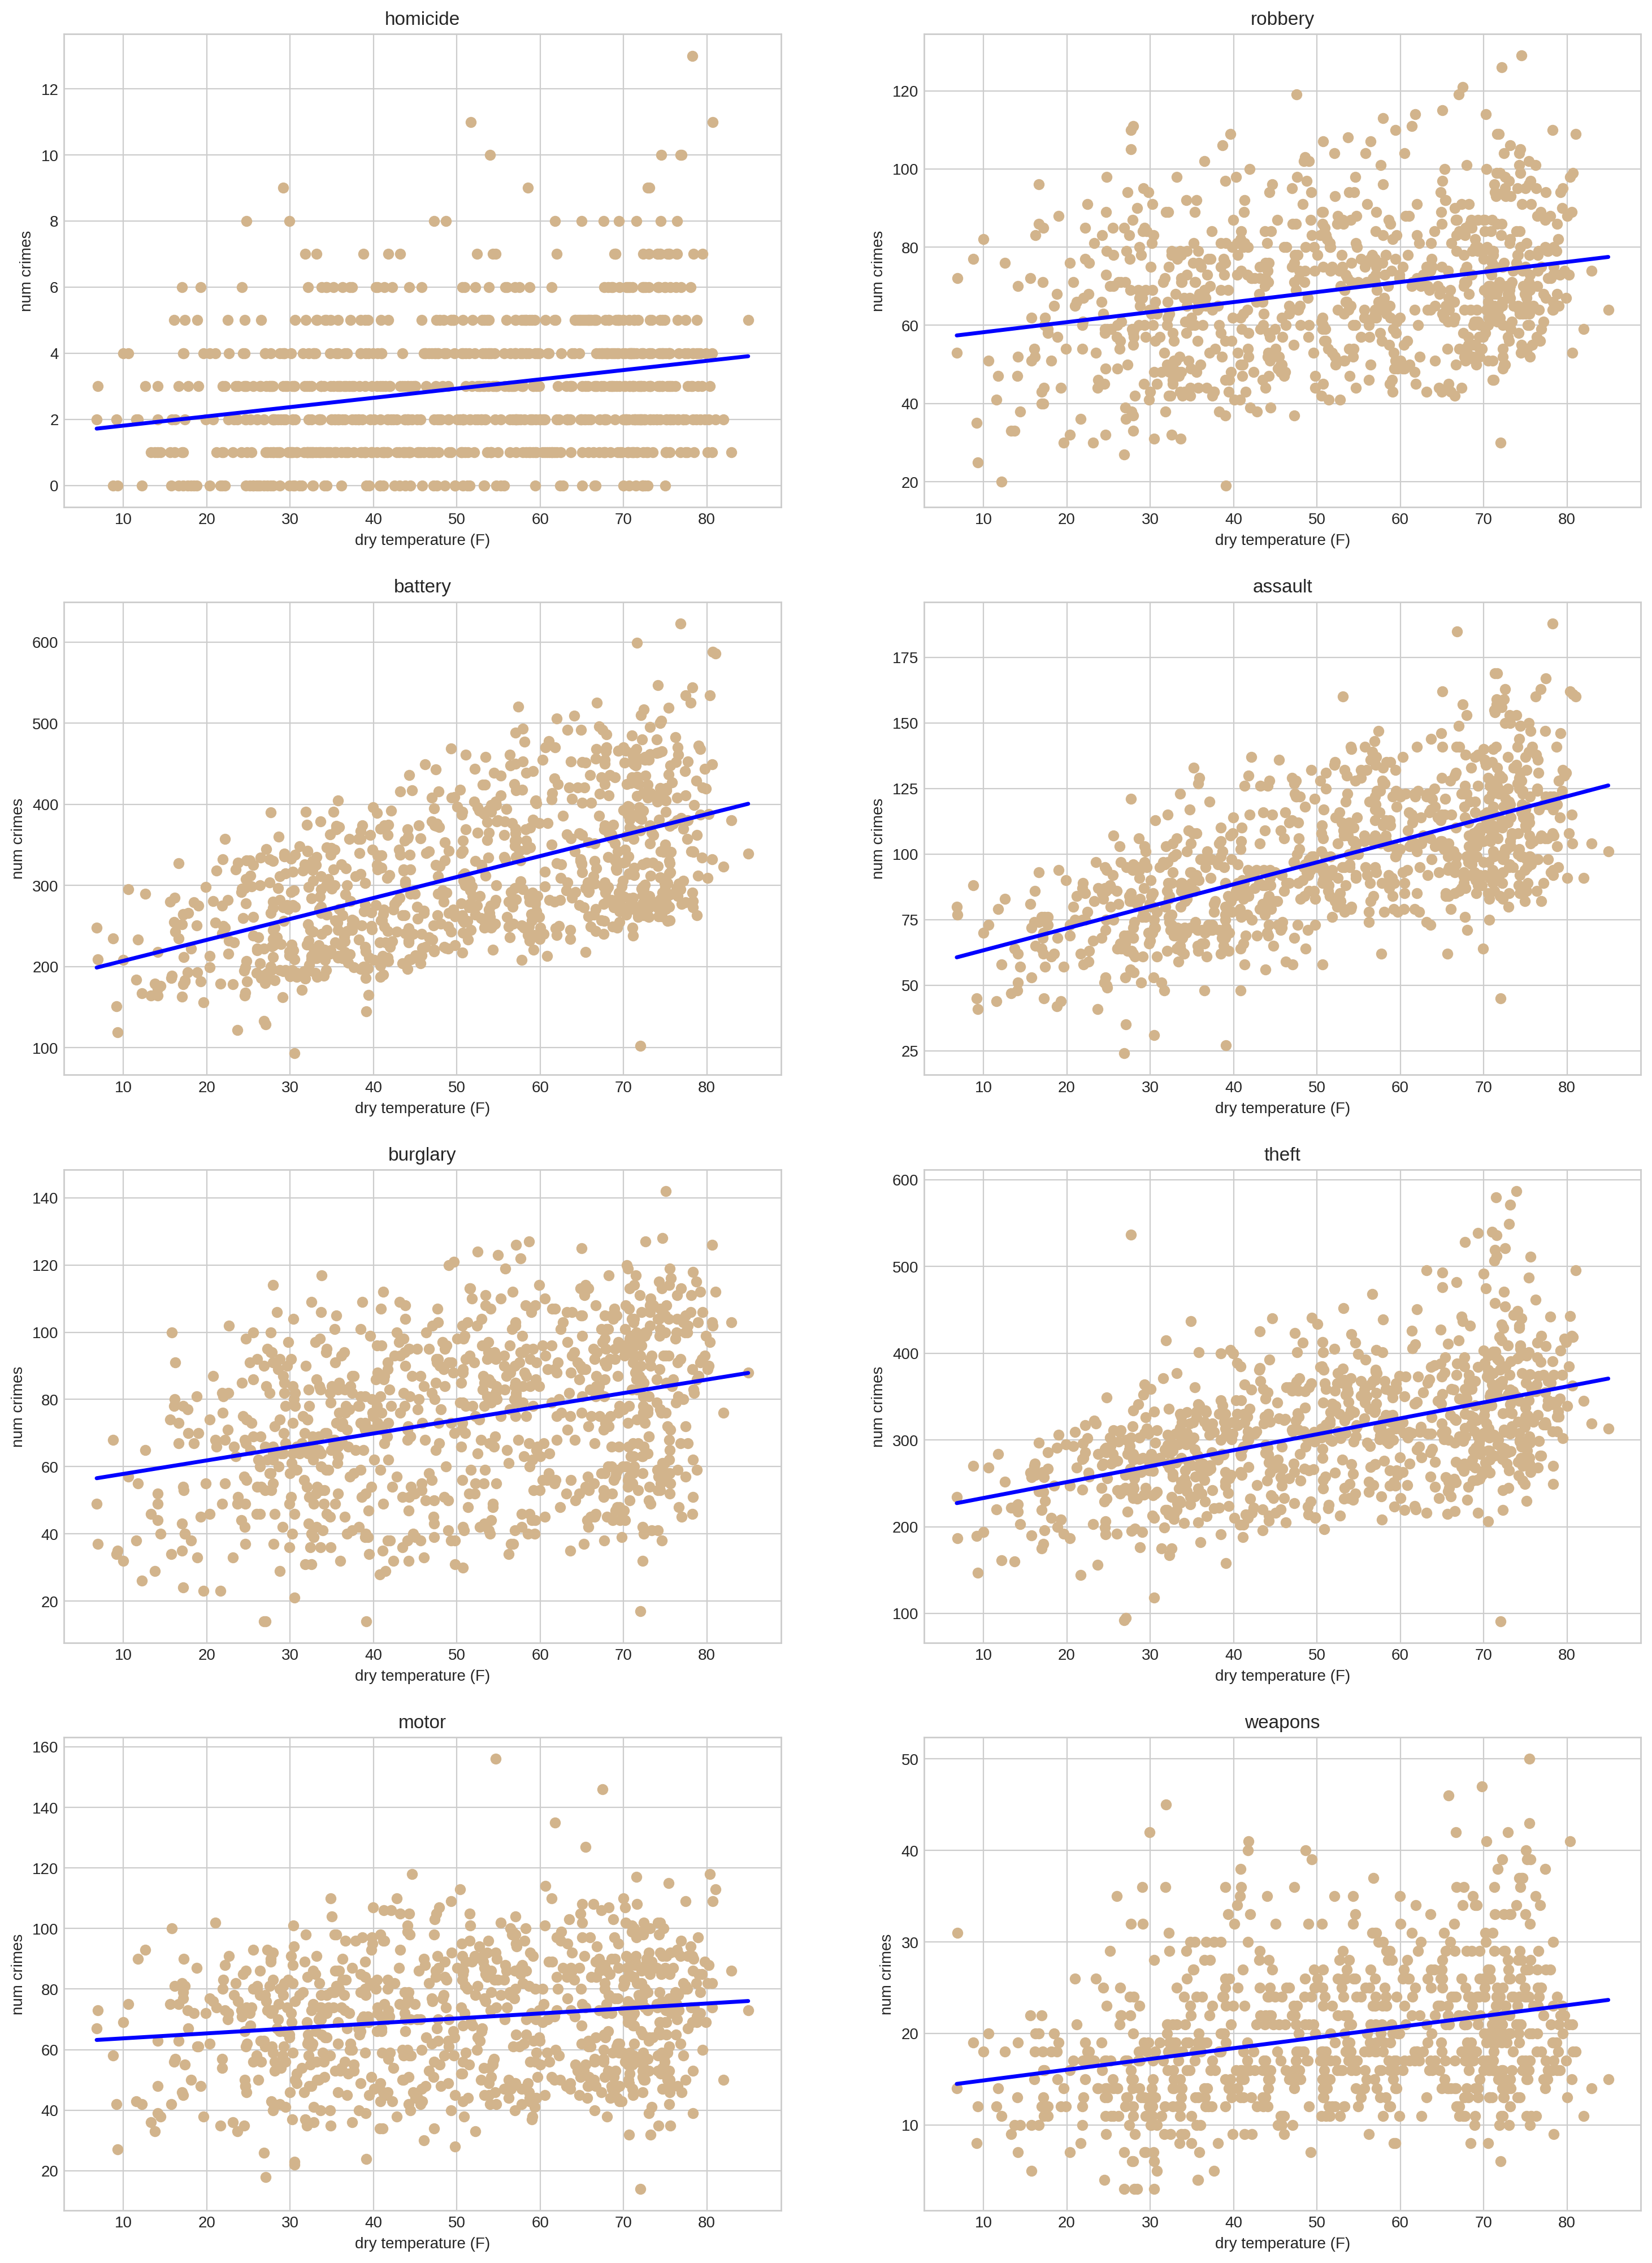

In [6]:
# #############################################################################
# Number of crimes versus dry bulb temperature

def scatter_crime(data):
    col = ['homicide', 'robbery','battery', 'assault', 'burglary', 'theft', 'motor', 'weapons']
    xAxis = 'dry'
    plt.figure(figsize=(18,25))
    for i in range(len(col)):
        x = data[xAxis]
        y = data[col[i]]
        plt.subplot(4,2,i+1)  
        plt.scatter(x, y, color='tan')
        plt.title(col[i])
        plt.xlabel(xAxis + ' temperature (F)'), plt.ylabel('num crimes')
        plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), 'b-', lw=2.5)
    
    plt.show() 

district = '5'    

data = pd.read_csv('../Output/WeeklyOutput/wc'+district+'.csv', sep=',', low_memory=False, 
                   names = ['date', 'dry', 'wet', 'wind',
                            'humidity', 'district', 'homicide', 'robbery',
                            'battery', 'assault', 'burglary', 'theft',
                            'motor', 'weapons']).iloc[70:]
#data.head()
scatter_crime(data)

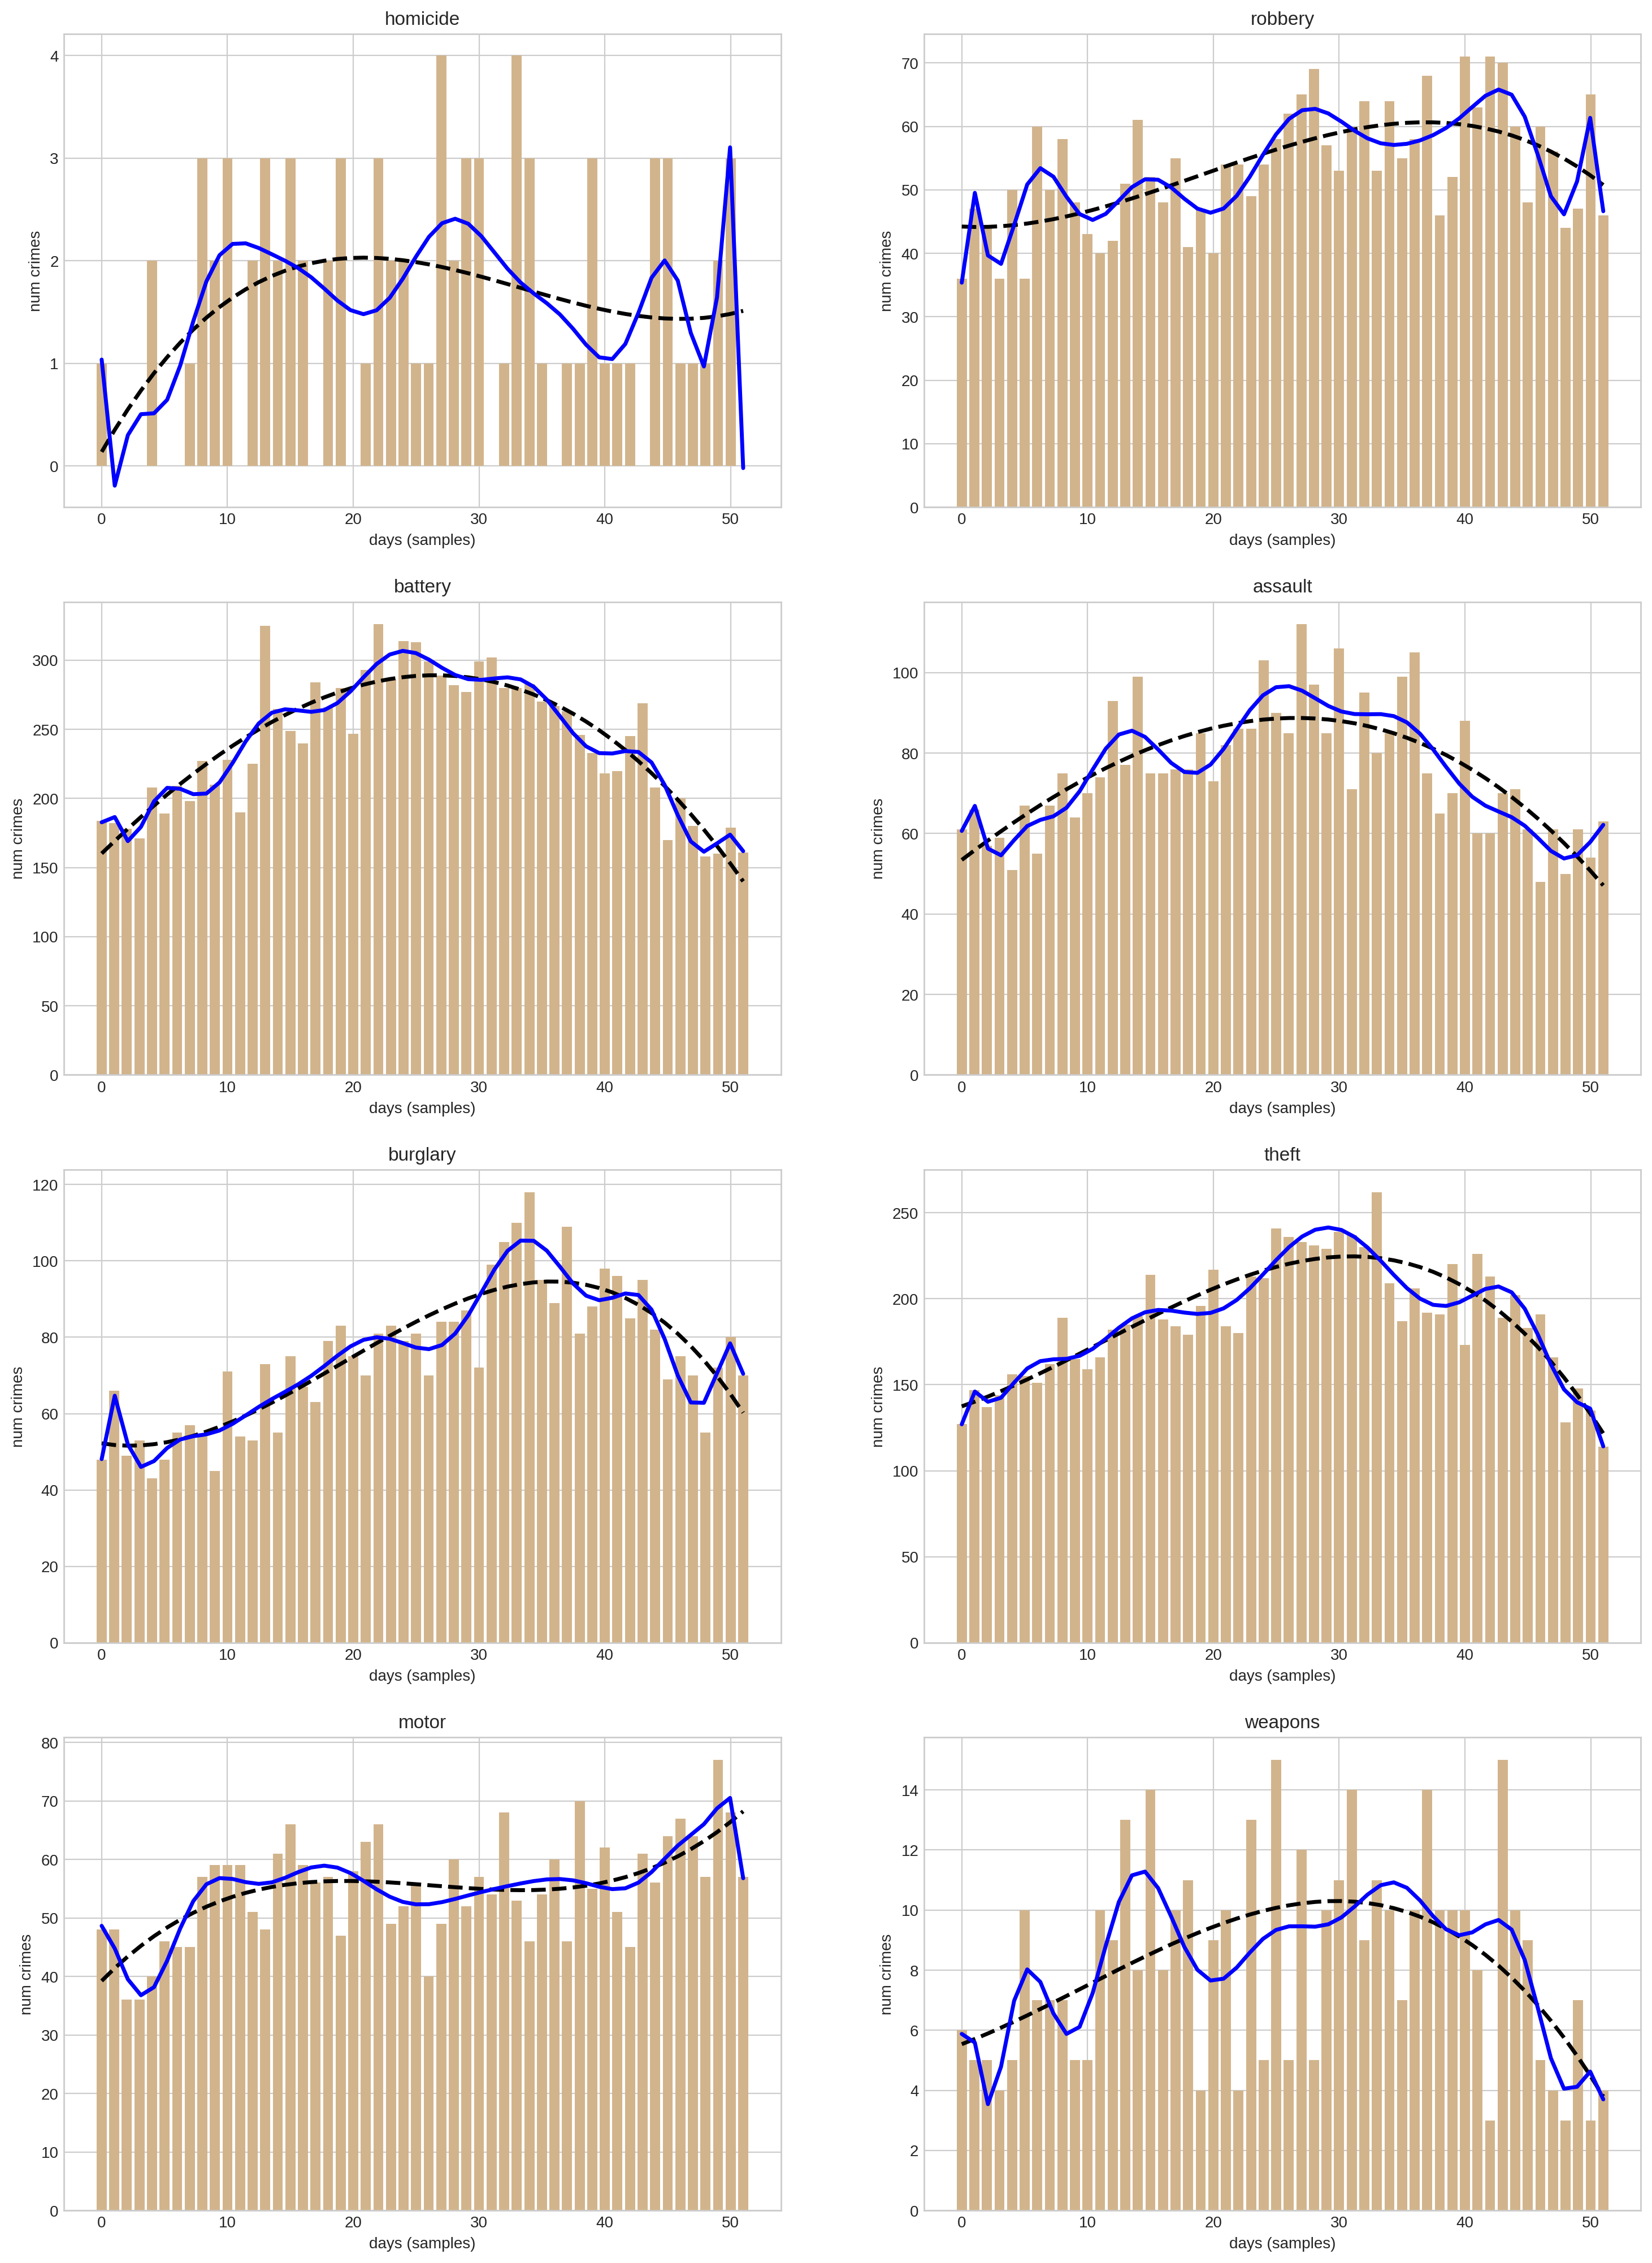

In [7]:
# #############################################################################
# Crimes over time by yearly subsets

def bar_crime(data, year):
    col = ['homicide', 'robbery','battery', 'assault', 'burglary', 'theft', 'motor', 'weapons']
    plt.figure(figsize=(18,25))
    
    for i in range(len(col)):
        plt.subplot(4,2,i+1)  
        y = data[col[i]][52*(year - 1):52*year]
        x = np.arange(len(y))
        z = np.polyfit(x, y, 3)
        
        p = np.poly1d(z)
        p30 = np.poly1d(np.polyfit(x, y, 15))
        xp = np.linspace(0, len(y) - 1, 50)
        
        plt.bar(x, y, color='tan')
        _ = plt.plot(xp, p(xp), 'k--', xp, p30(xp), 'b-', lw=2.5)
        plt.title(col[i])
        plt.xlabel('days (samples)'), plt.ylabel('num crimes') 
        
    plt.show() 

# Adjust year and district, 1-17 and 1-9 respectively

year = 5
district = '7'

data = pd.read_csv('../Output/WeeklyOutput/wc'+district+'.csv', sep=',', low_memory=False, 
               names = ['date', 'dry', 'wet', 'wind',
                        'humidity', 'district', 'homicide', 'robbery',
                        'battery', 'assault', 'burglary', 'theft',
                        'motor', 'weapons'])
data.head()
bar_crime(data, year)

In [5]:
# #############################################################################
# Read in data for rest of experiments

district = '5'

data = pd.read_csv('../Output/WeeklyOutput/wc'+district+'.csv', sep=',', low_memory=False, 
                   names = ['date', 'dry', 'wet', 'wind',
                            'humidity', 'district', 'homicide', 'robbery',
                            'battery', 'assault', 'burglary', 'theft',
                            'motor', 'weapons']).iloc[70:]

In [6]:
# #############################################################################
# Sample the data

data.head()

date        dry        wet       wind   humidity  district  homicide  \
70  2002019  55.300597  46.023070  11.919776  75.667710         5         0   
71  2002020  50.375813  40.002101  10.840935  69.820305         5         2   
72  2002021  53.132266  39.949343  10.799391  63.884654         5         4   
73  2002022  71.641154  55.016883   8.292236  58.253488         5         1   
74  2002023  64.884216  55.976088   7.829345  76.281591         5         2   

    robbery  battery  assault  burglary  theft  motor  weapons  
70       77      435      132        75    368    102       24  
71       83      418      128        79    384    113       17  
72       87      424      160        83    382     91       29  
73      109      599      169        83    358     98       25  
74       89      492      146       105    342     80       19

In [7]:
# #############################################################################
# Check for NaN / Missing values and dtype

data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 861 entries, 70 to 930
Data columns (total 14 columns):
date        861 non-null int64
dry         861 non-null float64
wet         861 non-null float64
wind        861 non-null float64
humidity    861 non-null float64
district    861 non-null int64
homicide    861 non-null int64
robbery     861 non-null int64
battery     861 non-null int64
assault     861 non-null int64
burglary    861 non-null int64
theft       861 non-null int64
motor       861 non-null int64
weapons     861 non-null int64
dtypes: float64(4), int64(10)
memory usage: 94.3 KB


In [8]:
# #############################################################################
# Descriptive statistics that summarize the central tendency, 
# dispersion and shape of the entire data distribution

data.describe()

date         dry         wet        wind    humidity  district  \
count  8.610000e+02  861.000000  861.000000  861.000000  861.000000     861.0   
mean   2.010091e+06   51.478171   40.679071    8.731308   69.381991       5.0   
std    4.758235e+03   18.627480   17.250642    2.073686    7.615422       0.0   
min    2.002019e+06    6.800146   -4.436644    3.165942   45.184700       5.0   
25%    2.006024e+06   35.687906   26.626688    7.225694   64.564113       5.0   
50%    2.010030e+06   53.157003   40.884912    8.628984   69.598956       5.0   
75%    2.014036e+06   68.999972   57.032660   10.159761   74.736478       5.0   
max    2.018041e+06   84.957466   72.141594   15.418848   94.367239       5.0   

         homicide     robbery     battery     assault    burglary       theft  \
count  861.000000  861.000000  861.000000  861.000000  861.000000  861.000000   
mean     2.970964   68.889663  314.180023   98.105691   74.463415  309.277584   
std      2.050602   17.591439   86.972938   25.272270   23.241655   71.356937   
min      0.000000   19.000000   93.000000   24.000000   14.000000   91.000000   
25%      1.000000   57.000000  250.000000   81.000000   56.000000  262.000000   
50%      3.000000   68.000000  299.000000   95.000000   75.000000  306.000000   
75%      4.000000   80.000000  374.000000  115.000000   92.000000  355.000000   
max     13.000000  129.000000  623.000000  188.000000  142.000000  587.000000   

            motor     weapons  
count  861.000000  861.000000  
mean    70.555168   19.728223  
std     19.824129    7.529971  
min     14.000000    3.000000  
25%     55.000000   14.000000  
50%     72.000000   18.000000  
75%     86.000000   24.000000  
max    156.000000   50.000000

### Neural Network

Using SGD from Dr. Anderson by use of the NN package.

In [9]:
# #############################################################################
# Normalize the data

cols_to_norm = ['dry', 'wet', 'wind', 'humidity']
data[cols_to_norm] = data[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

In [10]:
# #############################################################################
# Read in X and T by items in a list, e.g., [2, 3, 5], range(5), etc.

def sampler(data, a, b):
    
    X = data.iloc[:, np.r_[a]]
    T = data.iloc[:, np.r_[b]]
        
    return np.array(X), np.array(T)

X, T = sampler(data, [1, 2, 3, 4], range(6,14)) # 6,14

In [11]:
X[:5], T[:5]

(array([[0.62054905, 0.65893021, 0.71442919, 0.61979334],
        [0.55753788, 0.58030515, 0.62638144, 0.50090145],
        [0.59280589, 0.5796162 , 0.62299088, 0.38021529],
        [0.82962168, 0.77637628, 0.41837376, 0.26572008],
        [0.74316865, 0.78890209, 0.38059564, 0.63227502]]),
 array([[  0,  77, 435, 132,  75, 368, 102,  24],
        [  2,  83, 418, 128,  79, 384, 113,  17],
        [  4,  87, 424, 160,  83, 382,  91,  29],
        [  1, 109, 599, 169,  83, 358,  98,  25],
        [  2,  89, 492, 146, 105, 342,  80,  19]]))

In [12]:
# #############################################################################
# Return predicted values from training and running

def get_values(X, T, network, train_f, itr, partition = False):
    if partition: 
        Xtrain, Ttrain, Xtest, T = ml.partition(X, T, (train_f, 1 - train_f))
        
        nnet = nn.NeuralNetwork(Xtrain.shape[1], network, Ttrain.shape[1])
        nnet.train(Xtrain, Ttrain, itr)
        Y = nnet.use(Xtest)
        
    else:  
        nnet = nn.NeuralNetwork(X.shape[1], network, T.shape[1]) 
        nnet.train(X, T, itr)
        Y = nnet.use(X)
        
    return Y, T, nnet.getErrorTrace()

Network 1: [75] with 1200 iterations.
Network 2: [36] with 1260 iterations.
Network 3: [94] with 1323 iterations.
Network 4: [15, 40, 24, 29] with 1389 iterations.
Network 5: [15, 37, 84, 17] with 1458 iterations.
Network 6: [24, 9] with 1530 iterations.
Network 7: [24, 13] with 1606 iterations.
Network 8: [47, 61, 95] with 1686 iterations.
Network 9: [61, 15, 17] with 1770 iterations.
Network 10: [55, 83, 90, 89] with 1858 iterations.
Network 11: [11, 33, 46] with 1950 iterations.
Network 12: [77, 58, 34] with 2047 iterations.
Network 13: [57, 81, 62, 17, 9] with 2149 iterations.
Network 14: [69] with 2256 iterations.
Network 15: [67, 2, 92, 31] with 2368 iterations.
Network 16: [50, 3, 60] with 2486 iterations.
Network 17: [93, 77, 19] with 2610 iterations.
Network 18: [31, 18, 95] with 2740 iterations.
Network 19: [62, 86] with 2877 iterations.
Network 20: [27, 40, 72, 53, 13] with 3020 iterations.


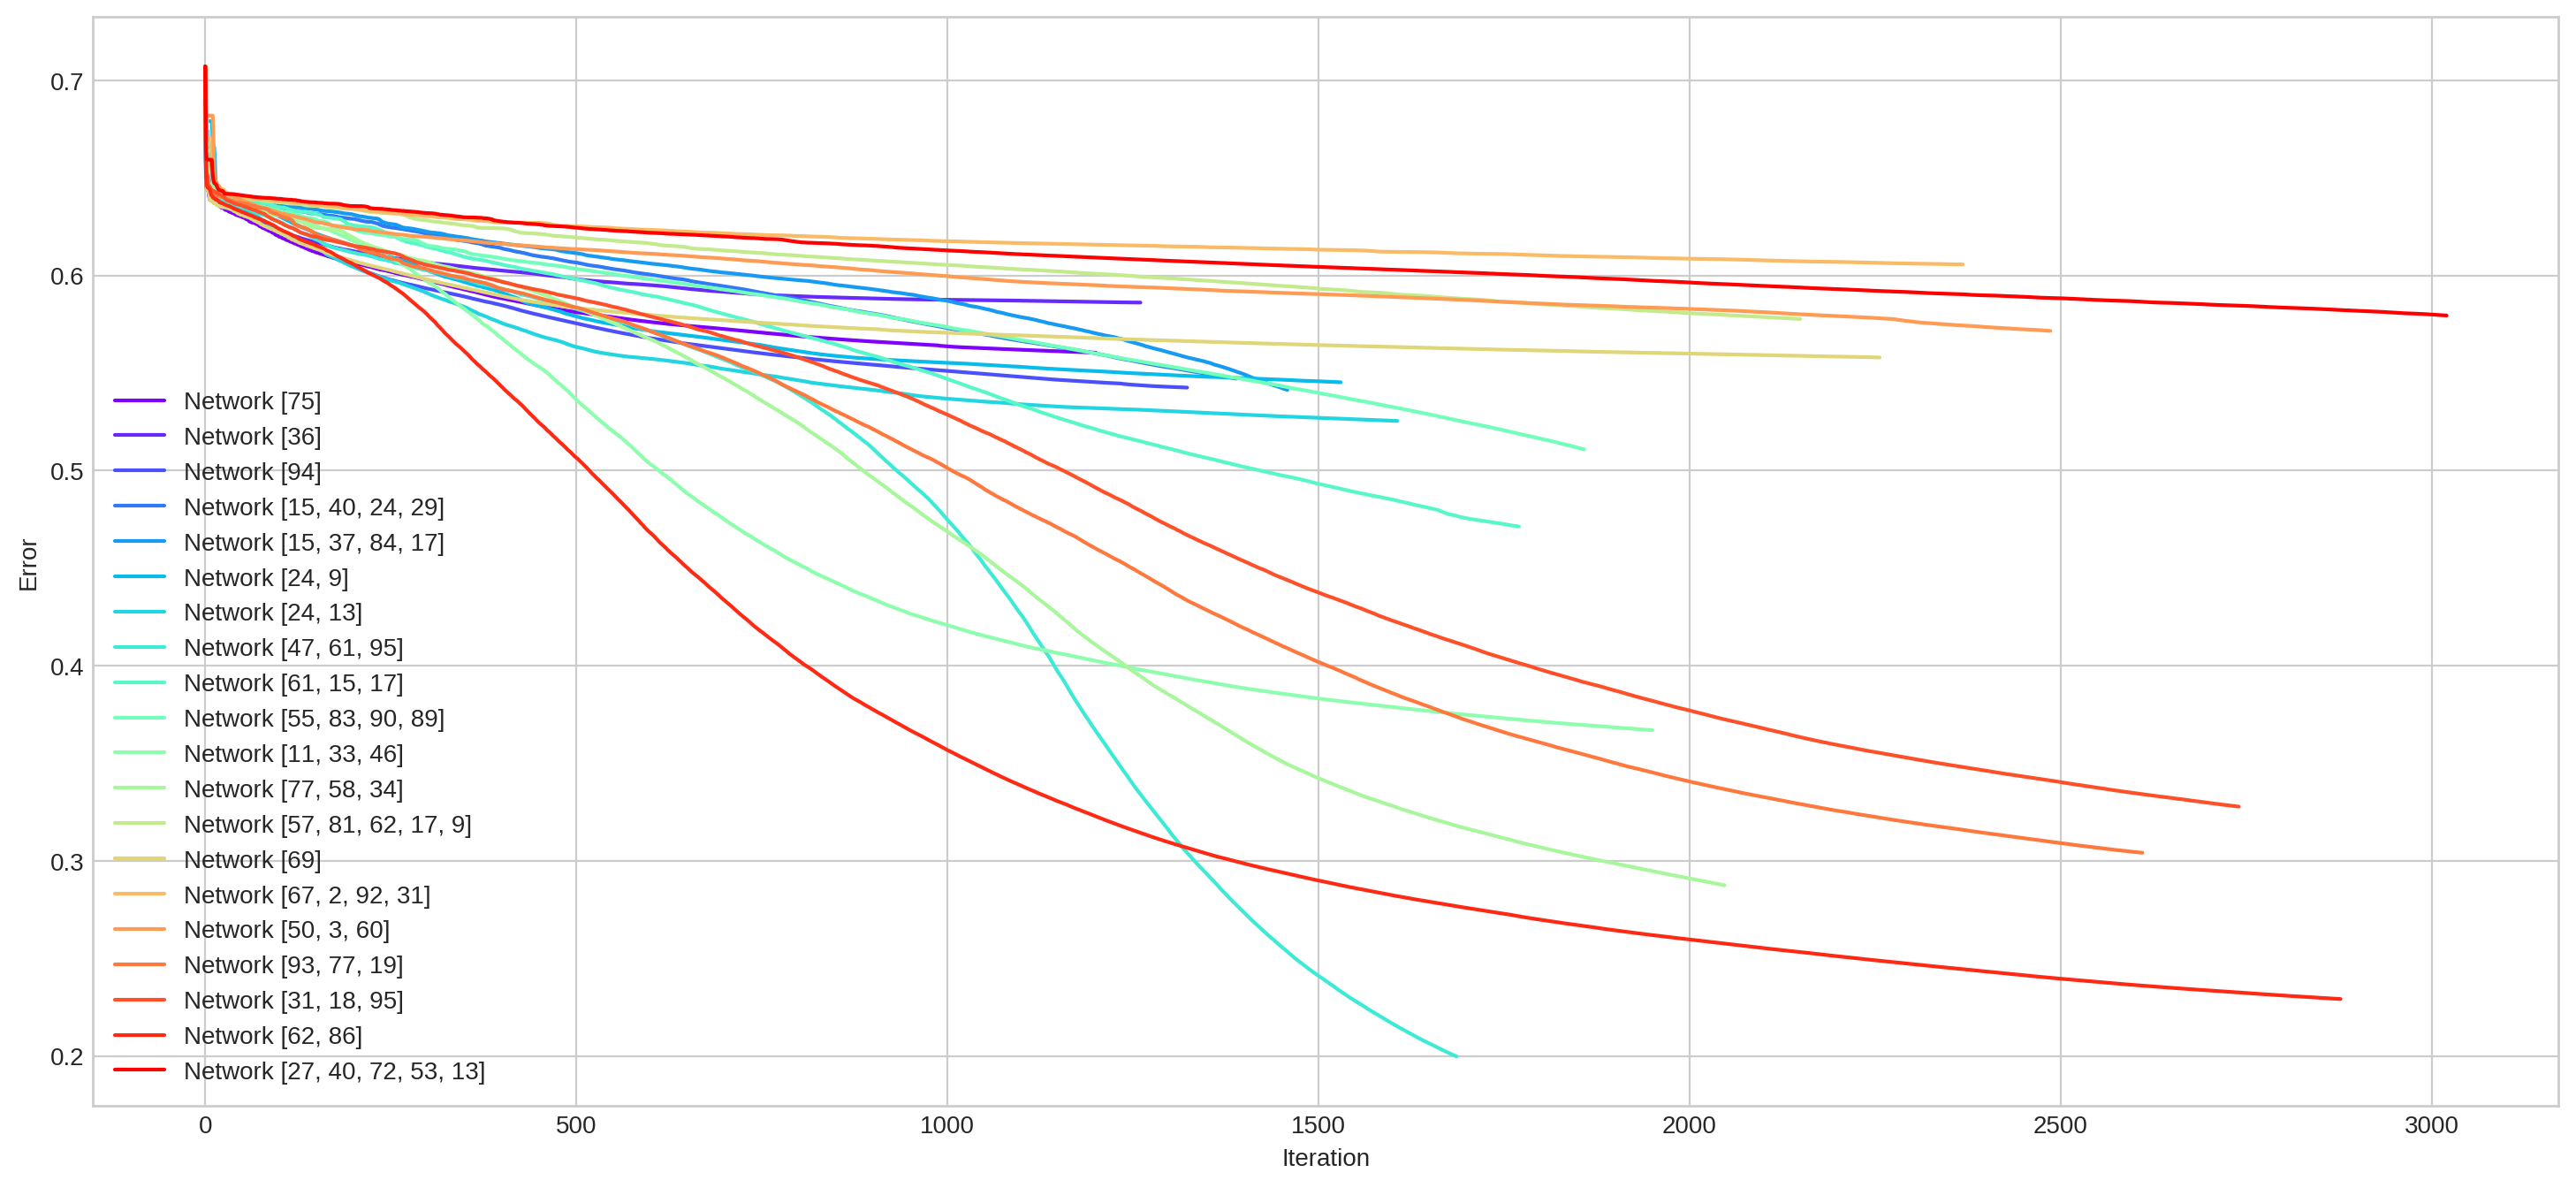

In [16]:
# #############################################################################
# Look at Error / Network / Iterations

sns.set_style("whitegrid")

numberItr = 1200
train_f = 0.8
er = []
networks = []
for i in range(20):
    a = random.sample(range(1, 100), np.random.randint(1, 6))
    print('Network', str(i+1) + ':', a,
          'with', numberItr, 'iterations.')

    Y, _T, error = get_values(X, T, a, train_f, numberItr)
    er.append(error)
    networks.append(a)
    numberItr = int(1.05 * numberItr)

color=iter(cm.rainbow(np.linspace(0,1,20)))
plt.figure(figsize=(18,8))
for i, pl in enumerate(er):
    plt.plot(pl, c=next(color), label = 'Network '+str(networks[i]))

plt.xlabel('Iteration')
plt.ylabel('Error')
plt.legend()
plt.show()

In [17]:
# #############################################################################
# Deeper network.  Found no difference when running.

'''
numberItr = 500
er = []

for i in range(14):
    a = np.random.randint(1, 50)
    b = np.random.randint(5, 20)
    print('Network', str(i+1) + ':', [a]*b,
          'with', numberItr, 'iterations.')

    Y, _T, error = get_values(X, T, [a]*b, train_f, numberItr)
    er.append(error)
    numberItr = int(1.15 * numberItr)

plt.figure(figsize=(18,6))
for i, pl in enumerate(er):
    plt.plot(pl, label = 'Network '+str(i+1))

plt.xlabel('Iteration')
plt.ylabel('Error')
plt.legend()
plt.show()
'''
print('check')

check


In [102]:
# #############################################################################
# Retrieve the best NN structure.  
# Best seen [67, 67, 67, 67] 2000 80/20 District 4
# MIN ERROR 0.49223388006888474, RMSE: 33.93454955140849
# [72, 72, 72, 72]
# ERROR MIN: 0.46960927770591065, RMSE: 35.984220552712344

itr = 50
hidden = []
trainFraction = 0.80
numberRepetitions = 5

for i in range(300):
    hidden.append(random.sample(range(1, 100), np.random.randint(1, 11)))

results = trainNNs(X, T, trainFraction, hidden,
                   numberRepetitions, itr)
summary = summarize(results)
best    = bestNetwork(summary)

pprint(summary)
printBest(best)

[[[91, 96, 71, 37], 35.26787960952254, 36.19685360021146, 2.076996088027954],
 [[42, 30, 75, 67, 15, 12],
  35.36881225755285,
  36.65303068852684,
  1.655991554260254],
 [[89, 84], 34.88118339913312, 36.930226253278626, 1.1893808841705322],
 [[37, 49, 57, 31, 91, 30, 58, 20, 63],
  35.717428629064536,
  35.675649921379616,
  2.574800491333008],
 [[48, 72], 34.718984786121005, 37.27769032108486, 0.820915699005127],
 [[97], 34.72835248479957, 37.0063684112096, 0.6025135517120361],
 [[39, 82, 90, 22, 77, 11, 83],
  35.33940201978133,
  36.747231729978495,
  2.6350064277648926],
 [[36, 70, 2, 81, 35, 60, 96],
  35.49317799746864,
  36.62941555216318,
  2.350832223892212],
 [[29, 75, 28], 35.29996506572023, 36.008538934353986, 0.8874657154083252],
 [[53, 92, 80, 93, 18],
  35.334634538525975,
  36.24085093503884,
  2.3363986015319824],
 [[90, 12, 54, 83, 6, 50, 41, 77, 7, 58],
  35.96366996705838,
  35.821695749841204,
  2.6534245014190674],
 [[45, 71, 18], 35.08645309720593, 37.1427383906

Network: 0
ERROR MIN: 0.6404013640021404 for 50 iterations
RMSE: 33.592232998407255


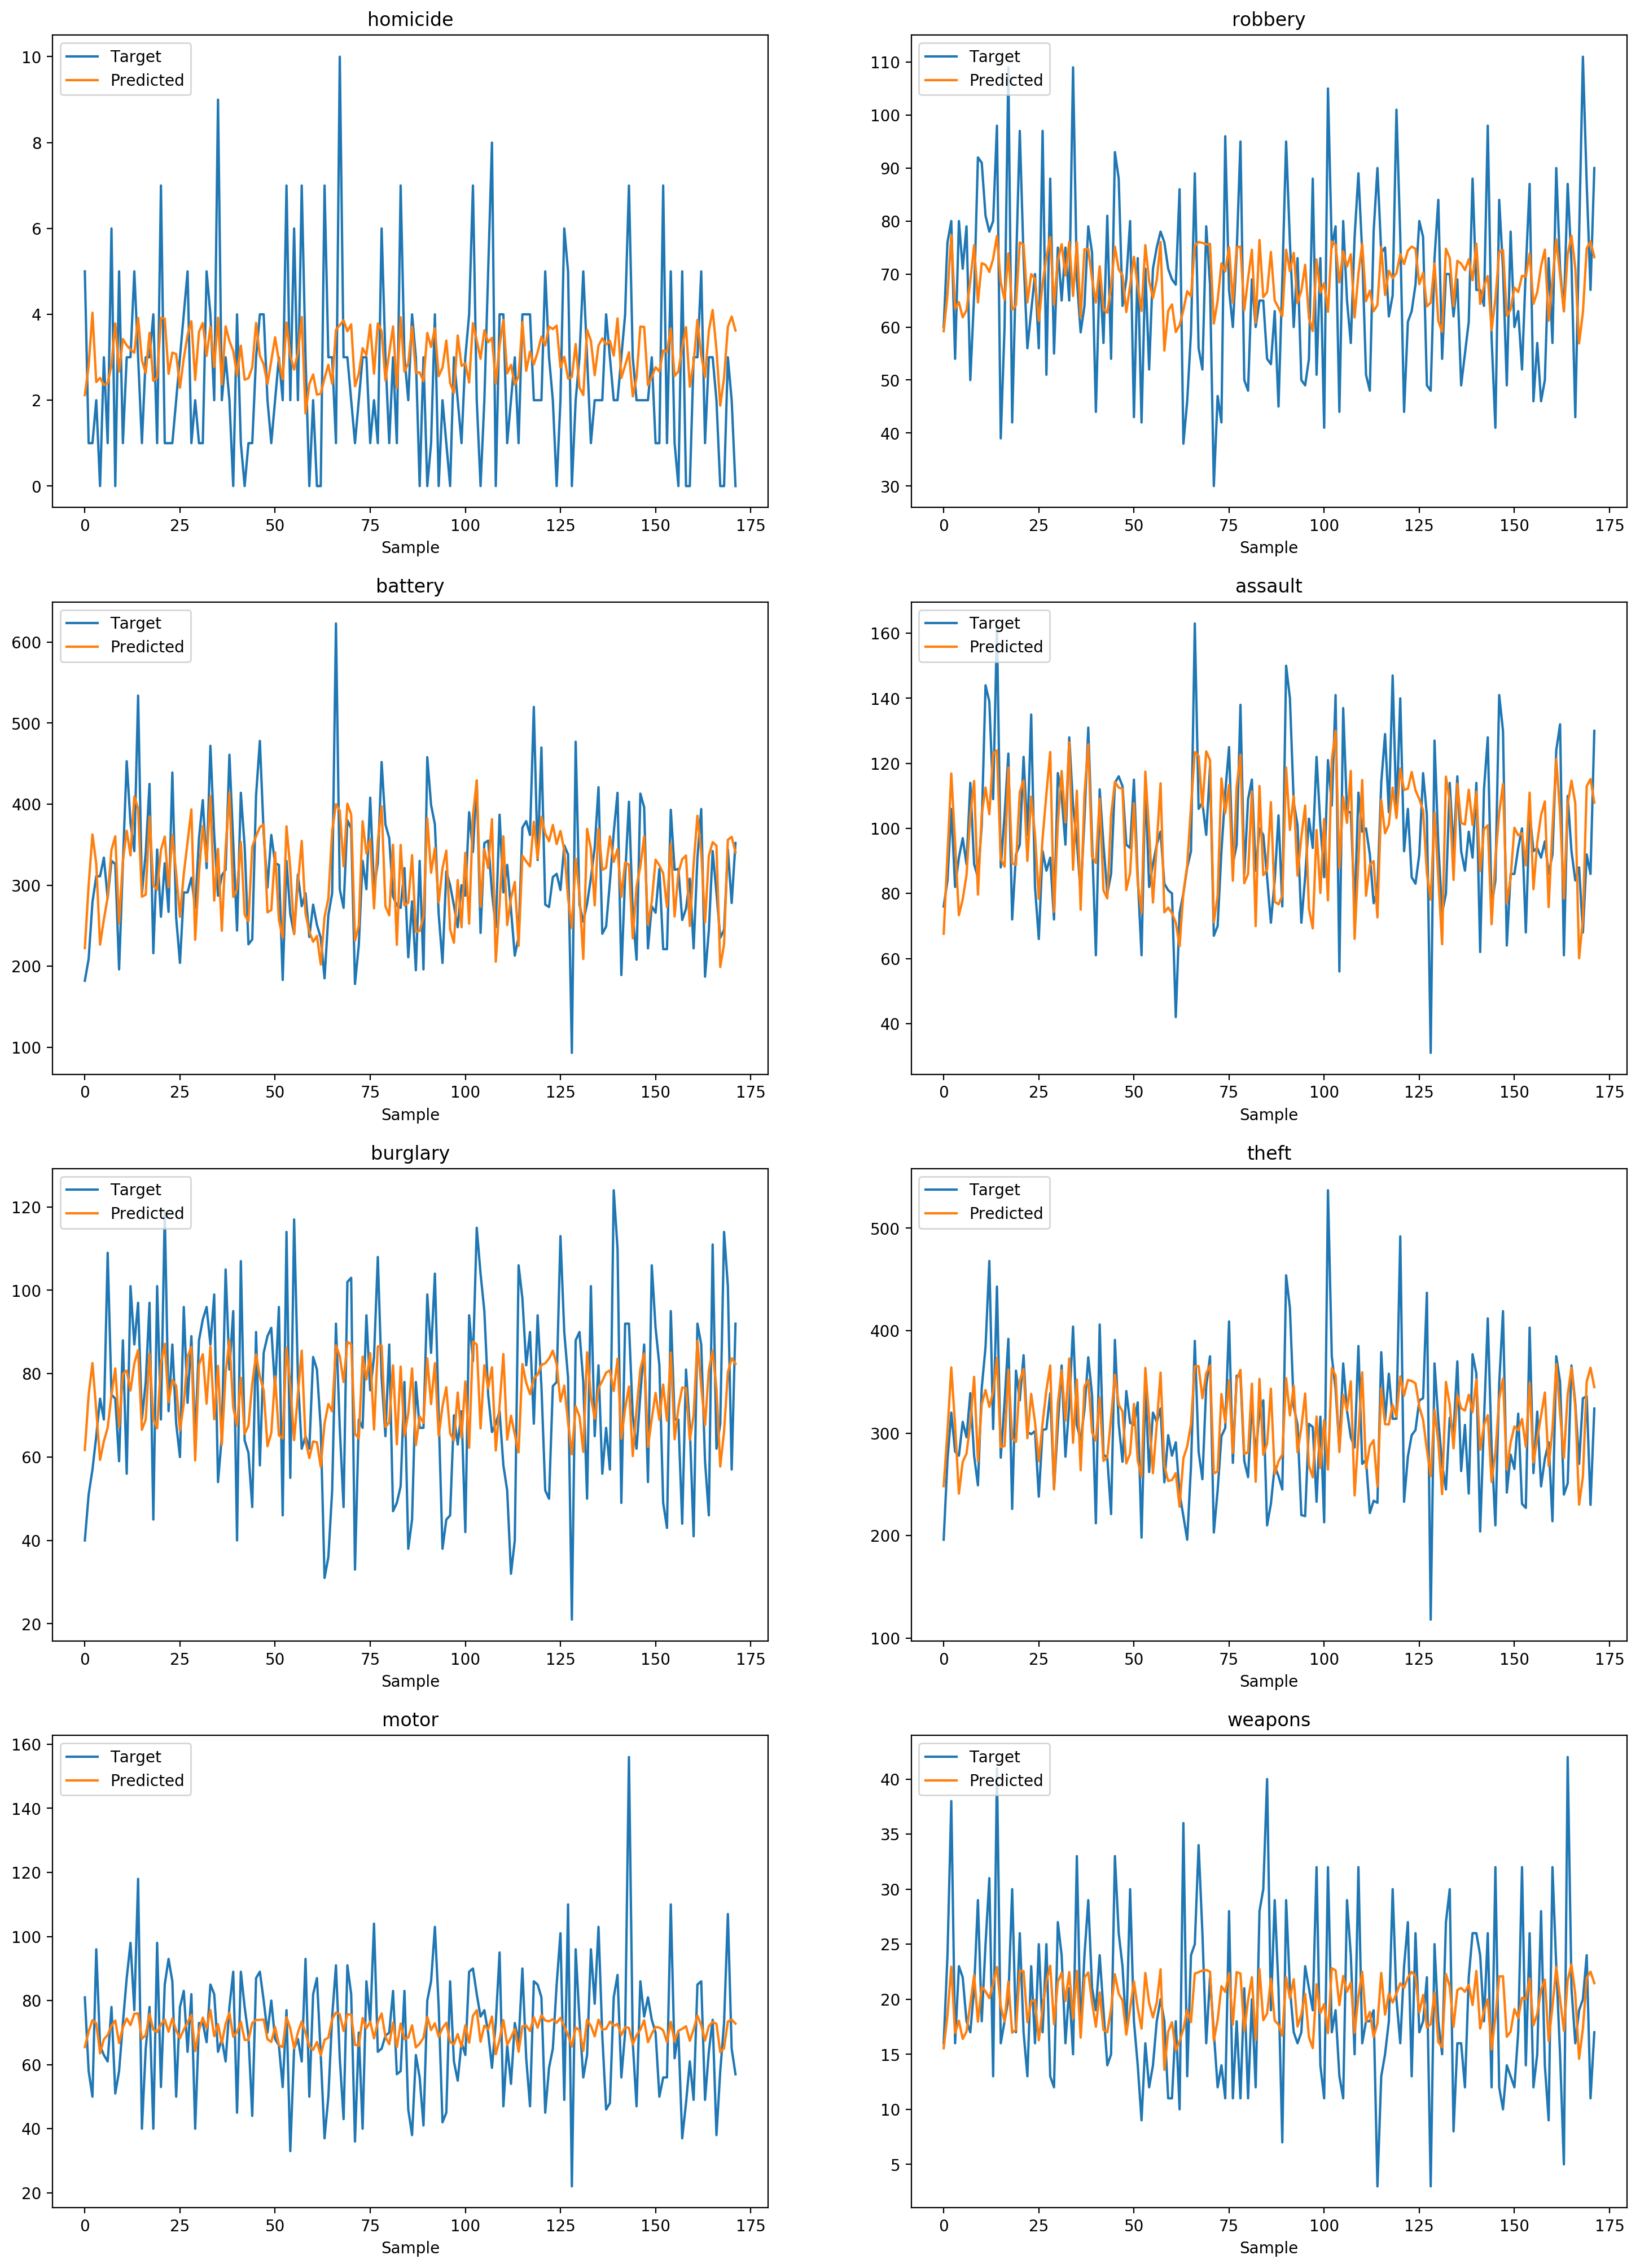

In [20]:
# #############################################################################
# Use the best network
    
itr = 50
train_f = 0.80

network = 0 #best[0]
print('Network:', network)
Y, _T, error = get_values(X, T, network, train_f, itr, partition = True)

# #############################################################################
# Results V1.  Showing first 200 samples 

def data_plot(Y, T, error, itr, bound):
    print('ERROR MIN:', np.min(error), 'for', itr, 'iterations')
    print('RMSE:', np.sqrt(np.mean((Y - T)**2)))
    col = ['homicide', 'robbery','battery', 'assault', 'burglary', 'theft', 'motor', 'weapons']
    
    plt.figure(figsize=(18,25))
    for i in range(T.shape[1]):
        plt.subplot(4,2,i+1)  
        plt.plot(T[:bound,i]), plt.plot(Y[:bound,i])
        plt.title(col[i])
        plt.xlabel('Sample'), plt.ylabel('')
        plt.legend(['Target', 'Predicted'], loc='upper left')
    
    plt.show() 
    
bound = 200
data_plot(Y, _T, error, itr, bound)

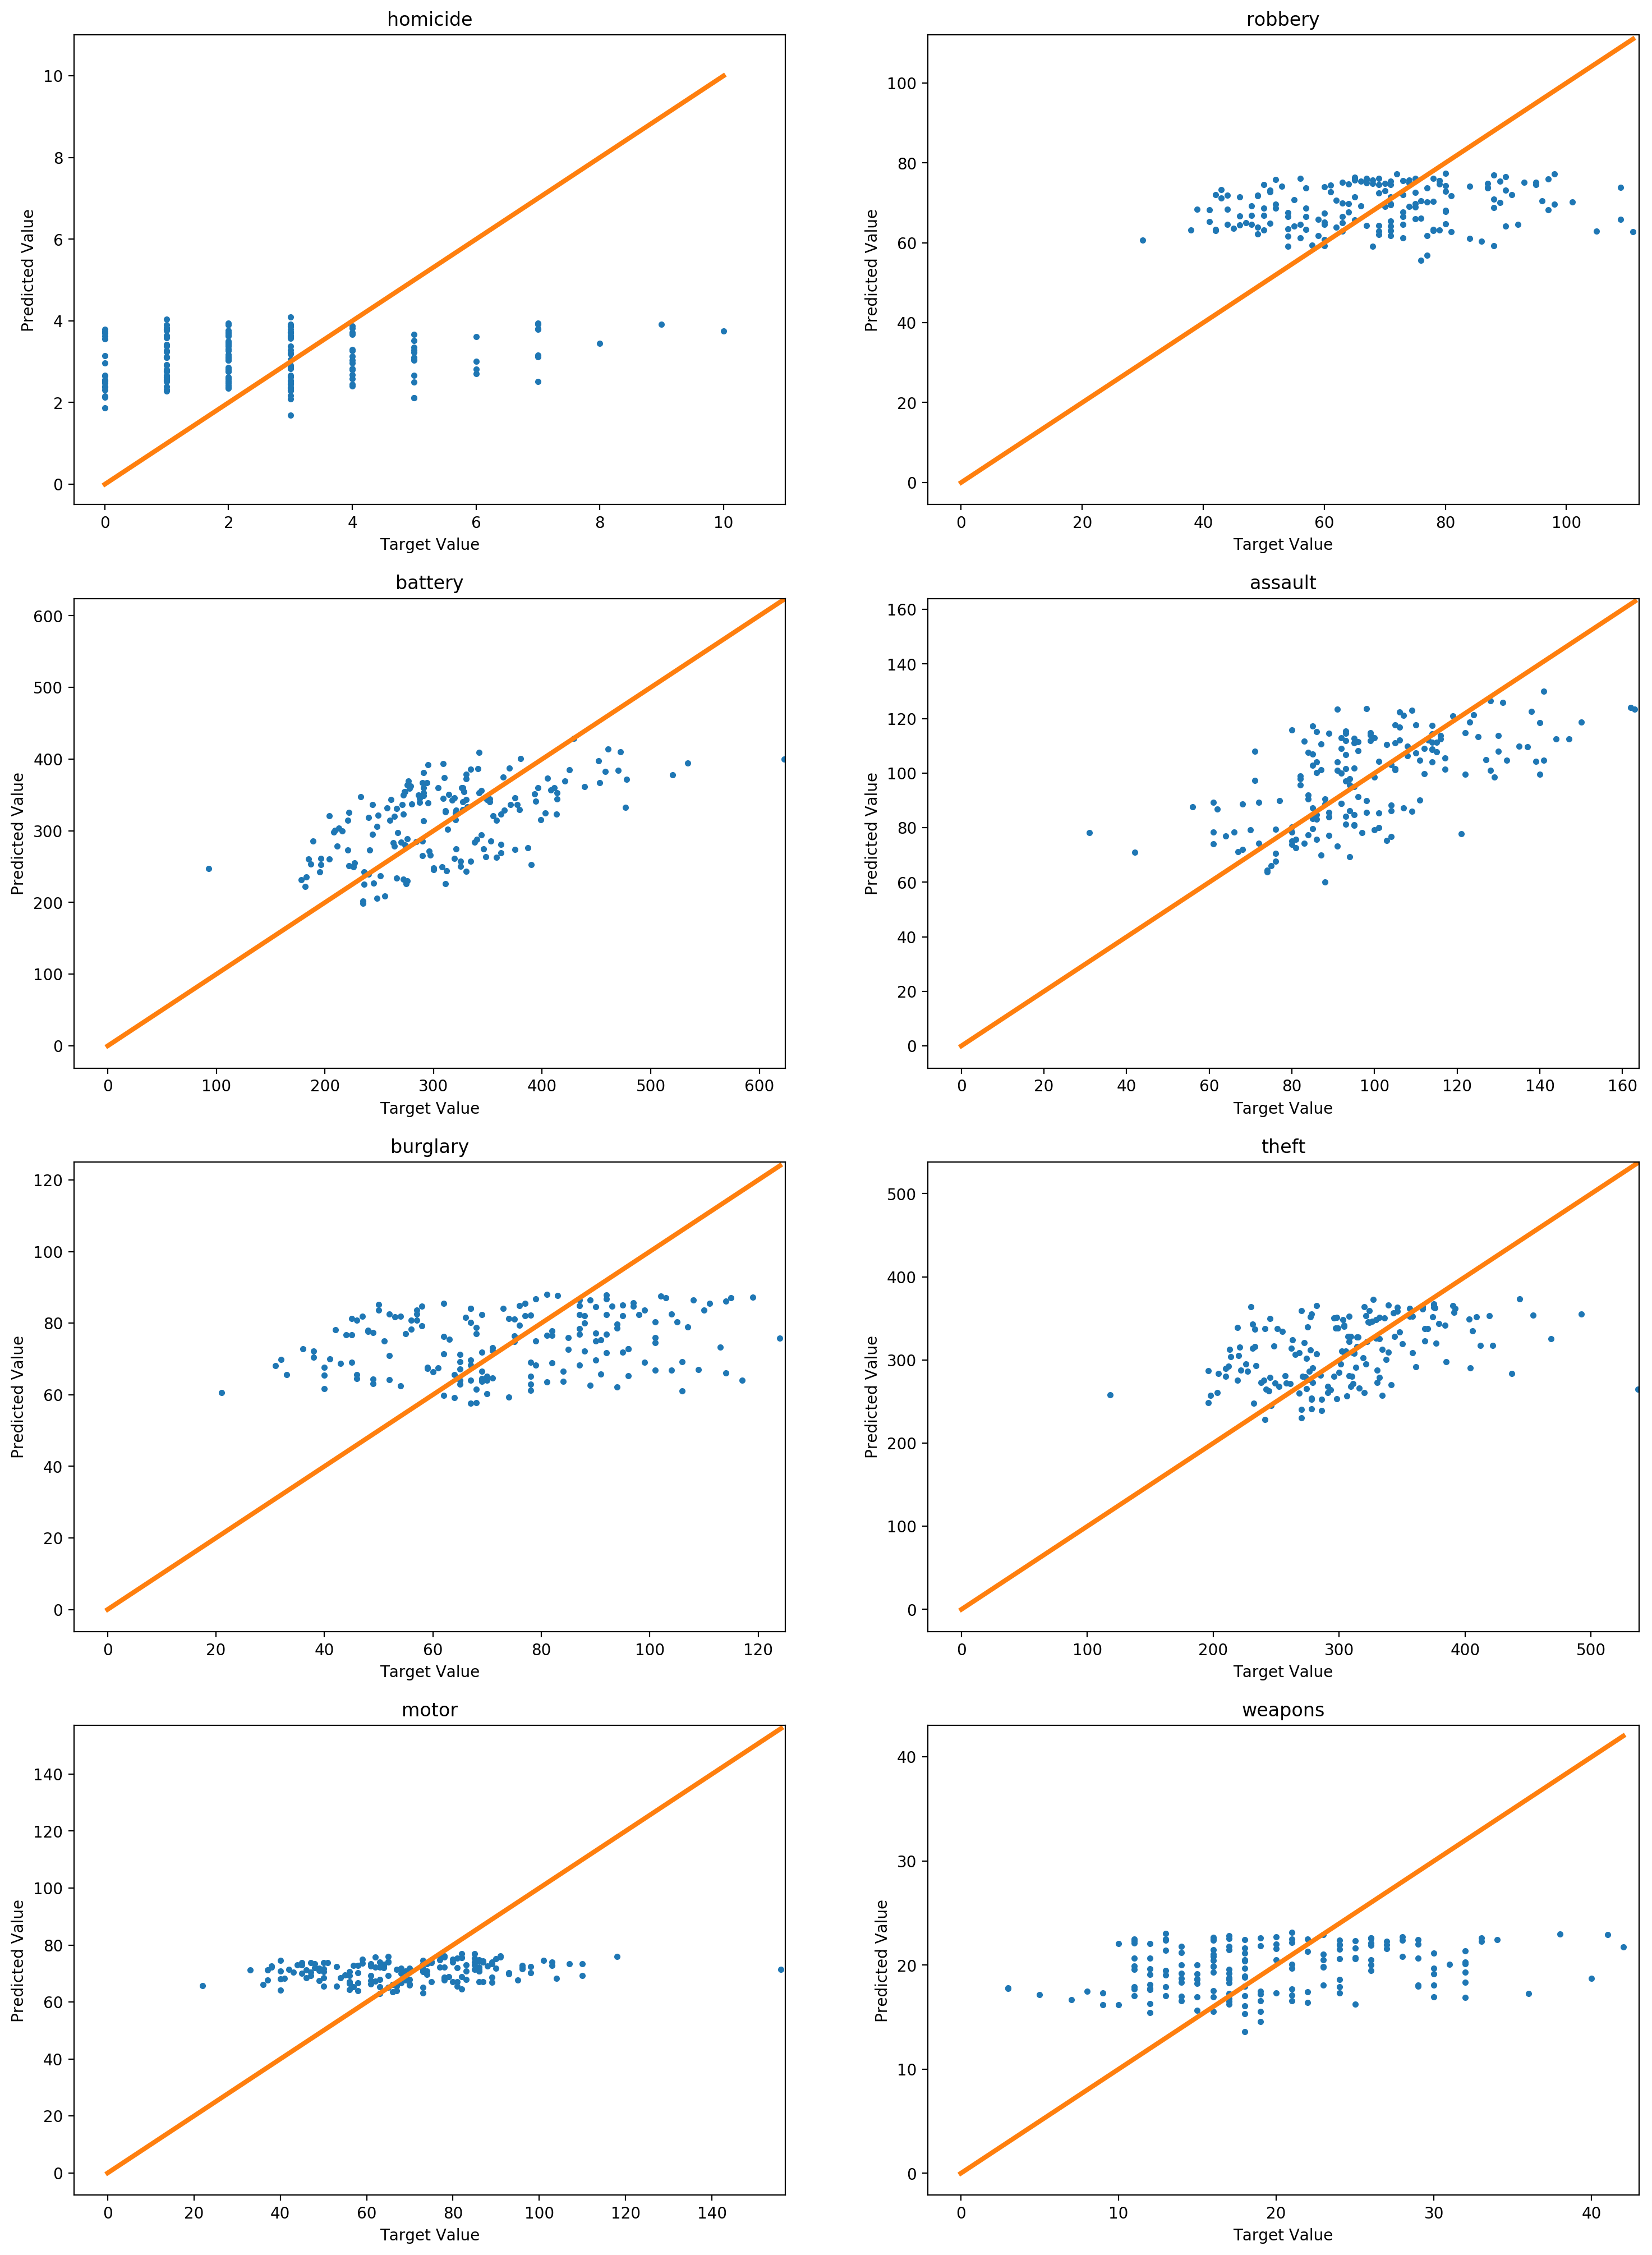

In [21]:
# #############################################################################
# Results V2

col = ['homicide', 'robbery','battery', 'assault', 'burglary', 'theft', 'motor', 'weapons']

plt.figure(figsize=(18,25))

for i in range(T.shape[1]):
    m = np.max(_T[:,i]) + 1
    plt.subplot(4,2,i+1)  
    plt.plot(_T[:,i], Y[:,i], '.'), plt.plot(range(m), lw='3')
    axes = plt.gca()
    axes.set_xlim([None,m]), axes.set_ylim([None,m])
    plt.title(col[i])
    plt.xlabel('Target Value'), plt.ylabel('Predicted Value')
    
plt.show()

### Scikit-Learn

Estimators developed for regression:

- LinearRegression
- Ridge
- Lasso
- SVR (SBR, Linear, Ploynomial)

/usr/local/anaconda3-4.4.0/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Linear Regression
train score: 0.11716716767608115
test score: 0.16732710409653495 

Ridge Regression, low alpha
train score: 0.11624807937320203
test score: 0.1635740060573898 

Ridge Regression, high alpha
train score: 0.07244420110908756
test score: 0.08128540774662107 



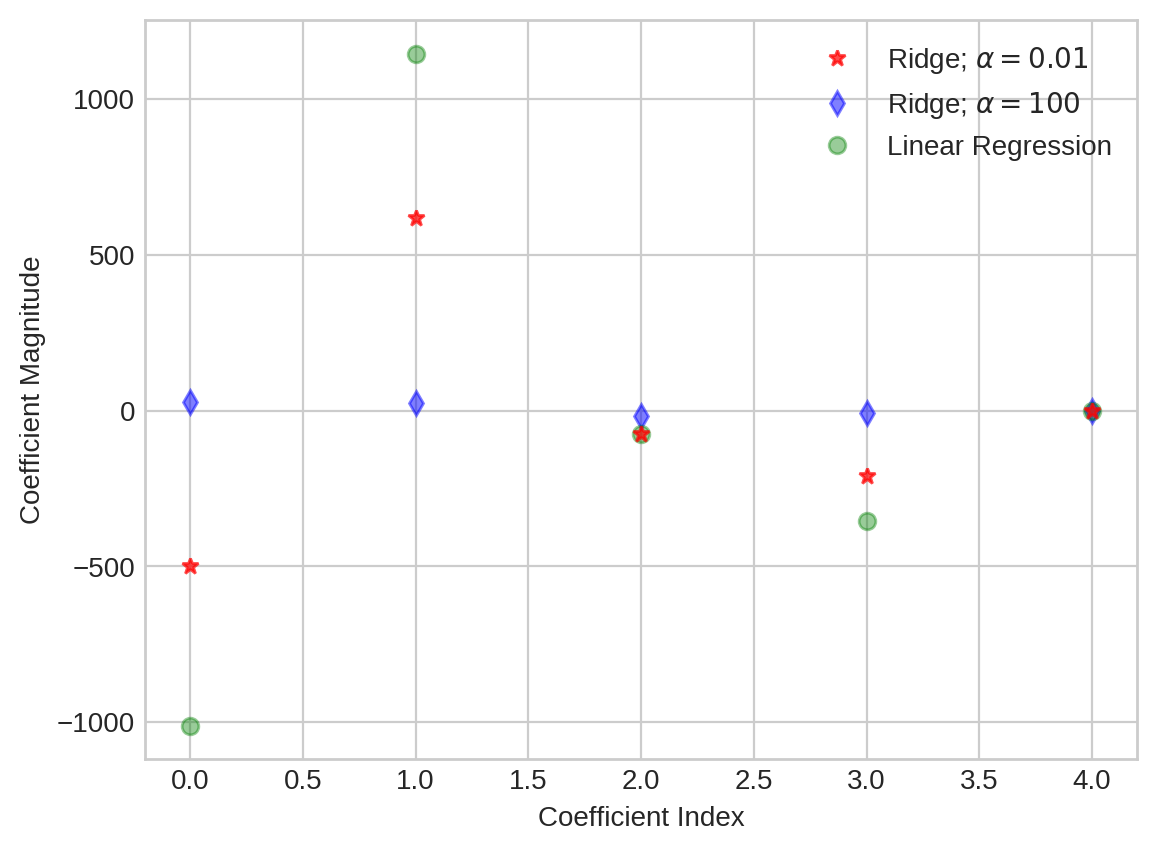

In [21]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

# #############################################################################
# Read the data
data = pd.read_csv('../Output/WeeklyOutput/wc5.csv', sep=',', low_memory=False, 
                   names = ['date', 'dry', 'wet', 'wind',
                            'humidity', 'district', 'homicide', 'robbery',
                            'battery', 'assault', 'burglary', 'theft',
                            'motor', 'weapons'])

cols_to_norm = ['dry', 'wet', 'wind', 'humidity']
data[cols_to_norm] = data[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

cols = ['homicide', 'robbery', 'battery', 'assault', 'burglary', 'theft', 'motor', 'weapons']

T = data['theft']
X = data.drop(['date'] + cols, axis=1)

X_train,X_test,T_train,T_test = train_test_split(X, T, test_size=0.3, random_state=3)

# #############################################################################
# Fit regression model
lr = LinearRegression()
lr.fit(X_train, T_train)

train_score = lr.score(X_train, T_train)
test_score = lr.score(X_test, T_test)

print('Linear Regression')
print("train score:", train_score)
print("test score:", test_score, '\n')

rr = Ridge(alpha=0.01)
rr.fit(X_train, T_train)

Ridge_train_score = rr.score(X_train, T_train)
Ridge_test_score = rr.score(X_test, T_test)

print('Ridge Regression, low alpha')
print("train score:", Ridge_train_score)
print("test score:", Ridge_test_score, '\n')

rr100 = Ridge(alpha=100)
rr100.fit(X_train, T_train)

Ridge_train_score100 = rr100.score(X_train, T_train)
Ridge_test_score100 = rr100.score(X_test, T_test)

print('Ridge Regression, high alpha')
print("train score:", Ridge_train_score100)
print("test score:", Ridge_test_score100, '\n')

# #############################################################################
# Results
plt.plot(rr.coef_, alpha=0.7, linestyle='none', marker='*',
         color='red', label=r'Ridge; $\alpha = 0.01$', zorder=7)
plt.plot(rr100.coef_, alpha=0.5, linestyle='none', marker='d',
         color='blue', label=r'Ridge; $\alpha = 100$')
plt.plot(lr.coef_, alpha=0.4, linestyle='none', marker='o',
         color='green', label='Linear Regression')

plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Magnitude')

plt.legend(loc=1)
plt.show()

alpha = 0.1
training score: 0.11352184973524627
test score:  0.1567442060808829
number of features used:  3 

alpha = 0.01
training score: 0.11568477987236568
test score:  0.16220643875094287
number of features used: 4 

alpha = 0.0001
training score: 0.11716701933665241
test score:  0.16728922062480867
number of features used: 4 



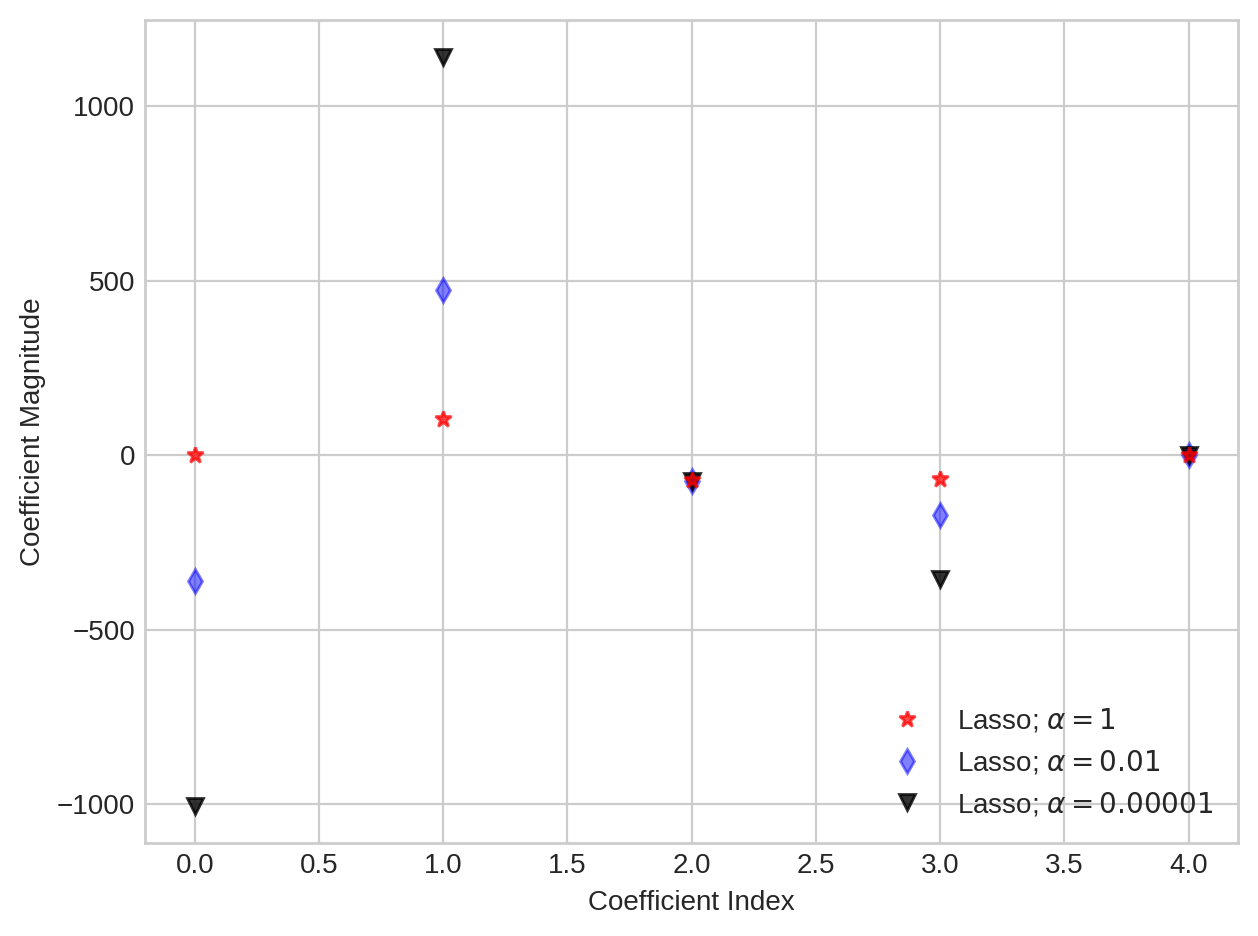

In [22]:
# Difference of lasso and ridge regression is that some of the coefficients can be zero i.e. some of the features are 
# completely neglected
from sklearn.linear_model import Lasso

# #############################################################################
# Read the Data
data = pd.read_csv('../Output/WeeklyOutput/wc5.csv', sep=',', low_memory=False, 
                   names = ['date', 'dry', 'wet', 'wind',
                            'humidity', 'district', 'homicide', 'robbery',
                            'battery', 'assault', 'burglary', 'theft',
                            'motor', 'weapons'])

cols_to_norm = ['dry', 'wet', 'wind', 'humidity']
data[cols_to_norm] = data[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

cols = ['homicide', 'robbery', 'battery', 'assault', 'burglary', 'theft', 'motor', 'weapons']

T = data['theft']
X = data.drop(['date'] + cols, axis=1)

X_train,X_test,T_train,T_test = train_test_split(X, T, test_size=0.3, random_state=3)

# #############################################################################
# Fit regression model
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, T_train)
train_score = lasso.score(X_train, T_train)
test_score = lasso.score(X_test, T_test)
coeff_used = np.sum(lasso.coef_!=0)

print('alpha = 0.1')
print("training score:", train_score)
print("test score: ", test_score)
print("number of features used: ", coeff_used, '\n')

lasso001 = Lasso(alpha=0.01, max_iter=10e6)
lasso001.fit(X_train, T_train)
train_score001 = lasso001.score(X_train, T_train)
test_score001 = lasso001.score(X_test, T_test)
coeff_used001 = np.sum(lasso001.coef_!=0)

print('alpha = 0.01')
print("training score:", train_score001)
print("test score: ", test_score001)
print("number of features used:", coeff_used001, '\n')

lasso00001 = Lasso(alpha=0.0001, max_iter=10e6)
lasso00001.fit(X_train, T_train)
train_score00001 = lasso00001.score(X_train, T_train)
test_score00001 = lasso00001.score(X_test, T_test)
coeff_used00001 = np.sum(lasso00001.coef_!=0)

print('alpha = 0.0001')
print("training score:", train_score00001)
print("test score: ", test_score00001)
print("number of features used:", coeff_used00001, '\n')

# #############################################################################
# Results
plt.plot(lasso.coef_, alpha=0.7, linestyle='none', marker='*',
         color='red', label=r'Lasso; $\alpha = 1$', zorder=7)
plt.plot(lasso001.coef_, alpha=0.5, linestyle='none', marker='d',
         color='blue', label=r'Lasso; $\alpha = 0.01$')
plt.plot(lasso00001.coef_, alpha=0.8, linestyle='none', marker='v',
         color='black', label=r'Lasso; $\alpha = 0.00001$')

plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Magnitude')
plt.legend(loc=4)

plt.tight_layout()
plt.show()

Kernel RBF
training score: 0.09445625830734228
Kernel Linear
training score: 0.09439768260209902
Kernel Ploy
training score: 0.08950597620289402


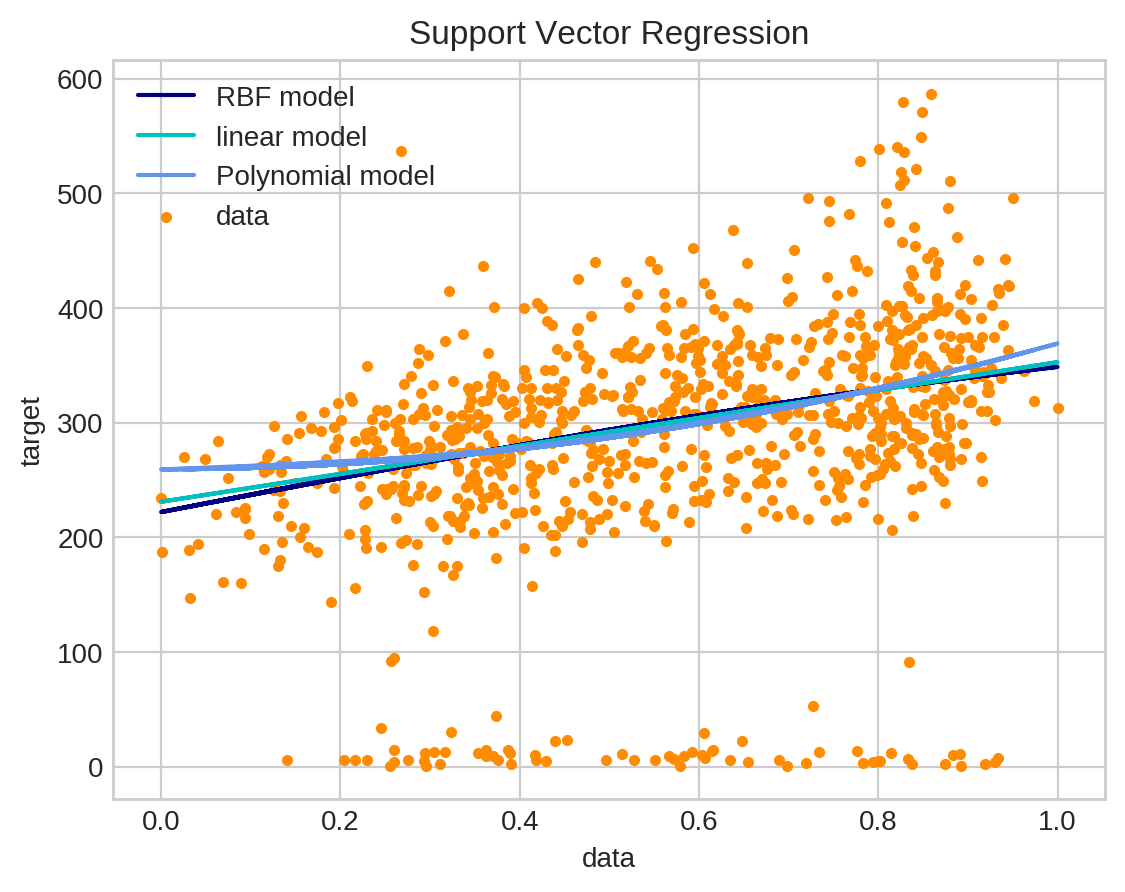

In [23]:
from sklearn.svm import SVR

# #############################################################################
# Read the Data
data = pd.read_csv('../Output/WeeklyOutput/wc5.csv', sep=',', low_memory=False, 
                   names = ['date', 'dry', 'wet', 'wind',
                            'humidity', 'district', 'homicide', 'robbery',
                            'battery', 'assault', 'burglary', 'theft',
                            'motor', 'weapons'])

cols_to_norm = ['dry', 'wet', 'wind', 'humidity']
data[cols_to_norm] = data[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

cols = ['homicide', 'robbery', 'battery', 'assault', 'burglary', 'theft', 'motor', 'weapons']

T = np.array(data['theft'])
X = np.array([[x] for x in data['dry']])

# X_train,X_test,T_train,T_test = train_test_split(X, T, test_size=0.3, random_state=3)

# #############################################################################
# Fit regression model

svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
y_rbf = svr_rbf.fit(X, T)
print('Kernel RBF')
print("training score:", y_rbf.score(X, T))
y_rbf = y_rbf.predict(X)

svr_lin = SVR(kernel='linear', C=1e3)
y_lin = svr_lin.fit(X, T)
print('Kernel Linear')
print("training score:", y_lin.score(X, T))
y_lin = y_lin.predict(X)

svr_poly = SVR(kernel='poly', C=1e3, degree=2)
y_poly = svr_poly.fit(X, T)
print('Kernel Ploy')
print("training score:", y_poly.score(X, T))
y_poly = y_poly.predict(X)

# #############################################################################
# Results

lw = 1.5
plt.scatter(X, T, marker='.', color='darkorange', label='data')

plt.plot(X, y_rbf, color='navy', lw=lw, label='RBF model')
plt.plot(X, y_lin, color='c', lw=lw, label='linear model')
plt.plot(X, y_poly, color='cornflowerblue', lw=lw, label='Polynomial model')

plt.xlabel('data')
plt.ylabel('target')
plt.title('Support Vector Regression')
plt.legend()
plt.show()

-- Jason Stock